# Quantium Virtual Project - Retail Strategy and Analytics on Potato Chips

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy.stats import pearsonr

## 1. Data Exploration

1. Load Dataset  
-  Transaction dataset  
-  Customer dataset

In [2]:
# Read files
customers = pd.read_csv('data/quantium_da/QVI_purchase_behaviour.csv')
transactions = pd.read_excel('data/quantium_da/QVI_transaction_data.xlsx')

### 1.1 Explore on transaction data

1. View data structure

In [3]:
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


From information listed as above:  
-  There are 8 columns and 264836 rows in total, no missing values.  
-  Data type of 'DATE' column is int64, should be converted into date.  
-  Data type of 'TXN_ID' column is int64, better to be converted into string.

2. Convert data type

In [5]:
# convert dtype of 'DATE' from int to date
transactions['DATE'] = pd.to_datetime(transactions['DATE'], origin='1899-12-30', unit='D')

# convert dtype of 'TXN_ID' from int to string
transactions['TXN_ID'] = transactions['TXN_ID'].astype(str)


In [6]:
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


3. Check outliers

In [7]:
# check 'PROD_QTY' column
transactions['PROD_QTY'].describe()

count    264836.000000
mean          1.907309
std           0.643654
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64

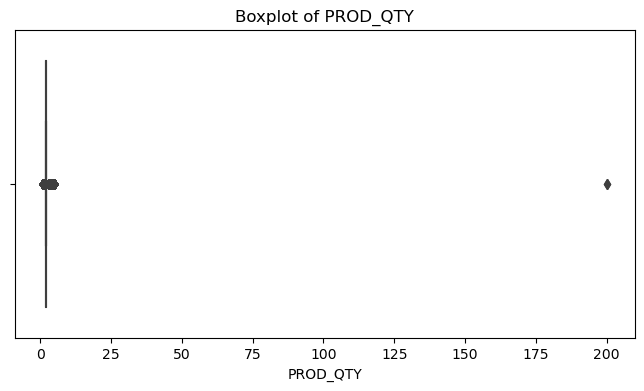

In [8]:
# plot boxplot of 'PROD_QTY' column
plt.figure(figsize=(8, 4))
sns.boxplot(x=transactions['PROD_QTY'])
plt.title("Boxplot of PROD_QTY")
plt.show()

From the statistics summary and boxplot of 'PROD_QTY' column, we can see the max amount 200 is much higher than the 75% percentile and all the other data points, it's an outlier. Take a close look at the transactions for the outlier to determine how to deal with it.

In [9]:
outlier_rows = transactions[transactions['PROD_QTY'] == 200]

outlier_rows

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [10]:
# view all transactions made by this customer
outlier_cust = transactions[transactions['LYLTY_CARD_NBR'] == 226000]

outlier_cust

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


 It looks like this customer has only had the two transactions over the year and is not an ordinary retail
 customer. The customer might be buying chips for commercial purposes instead. We’ll remove this loyalty
 card number from further analysis.

In [11]:
transactions = transactions[transactions['LYLTY_CARD_NBR'] != 226000]

In [12]:
# check 'TOT_SALES' column
transactions['TOT_SALES'].describe()

count    264834.000000
mean          7.299346
std           2.527241
min           1.500000
25%           5.400000
50%           7.400000
75%           9.200000
max          29.500000
Name: TOT_SALES, dtype: float64

4. Check consistency  

(1) Check if all the transactions are related to potato chips not other products. We can
 do somebasic text analysis by summarising the individual words in the product name.

In [13]:
# get unique product names
unique_prod_names = transactions['PROD_NAME'].unique()

# split names into words
word_list = [word for name in unique_prod_names for word in name.split()]

# convert to dataframe
product_words = pd.DataFrame(word_list, columns=['words'])

print(product_words)

           words
0        Natural
1           Chip
2         Compny
3    SeaSalt175g
4            CCs
..           ...
584         150g
585      Doritos
586        Salsa
587         Mild
588         300g

[589 rows x 1 columns]


In [14]:
# remove words that contain digits
product_words = product_words[~product_words['words'].str.contains(r'\d', regex=True)]

# remove words that do not contain at least one alphabetic character
product_words = product_words[product_words['words'].str.contains(r'[a-zA-Z]', regex=True)]

# count occurrences of each word
word_counts = product_words['words'].value_counts().reset_index()
word_counts.columns = ['words','count']

# sort by frequency in descending order
word_counts = word_counts.sort_values(by='count', ascending=False)

word_counts

,words,count
0,Chips,21
1,Smiths,16
2,Crinkle,14
3,Cut,14
4,Kettle,13
...,...,...
104,Balls,1
103,Slt,1
102,Vingar,1
101,SourCream&Herbs,1


There are salsa products in the dataset but we are only interested in the chips category, so let’s remove
 these.

In [15]:
# remove rows with 'PROD_NAME' column contains 'salsa'
transactions = transactions[~transactions['PROD_NAME'].str.contains('salsa', na=False)]

In [16]:
transactions.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,PROD_NBR,PROD_QTY,TOT_SALES
count,264834,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000
mean,2018-12-30 00:52:10.292938240,135.079423,1.355488e+05,56.583554,1.905813,7.299346
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.000000,7.002100e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.000000,1.303570e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030940e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,114.000000,5.000000,29.500000
std,NaN,76.784063,8.057990e+04,32.826444,0.343436,2.527241


(2) Review the number of transaction lines over time to see if there are any obvious data
 issues such as missing data.

In [17]:
# group by 'DATE' and count transactions
tx_by_day = transactions.groupby('DATE').size().reset_index(name='N')

tx_by_day

,DATE,N
0,2018-07-01,724
1,2018-07-02,711
2,2018-07-03,722
3,2018-07-04,714
4,2018-07-05,712
...,...,...
359,2019-06-26,723
360,2019-06-27,709
361,2019-06-28,730
362,2019-06-29,745


There’s only 364 rows, meaning only 364 dates which indicates a missing date. So we create a sequence of
 dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to
 find the missing date.

In [18]:
# create a full sequence of dates
all_dates = pd.DataFrame({'DATE':pd.date_range(start='2018-07-01', end='2019-06-30')})

# merge with tx_by_day to ensure all dates are present
tx_by_day = all_dates.merge(tx_by_day, on='DATE', how='left')

# fill missing transaction counts with 0
tx_by_day['N'].fillna(0, inplace=True)

tx_by_day.head()

,DATE,N
0,2018-07-01,724.0
1,2018-07-02,711.0
2,2018-07-03,722.0
3,2018-07-04,714.0
4,2018-07-05,712.0


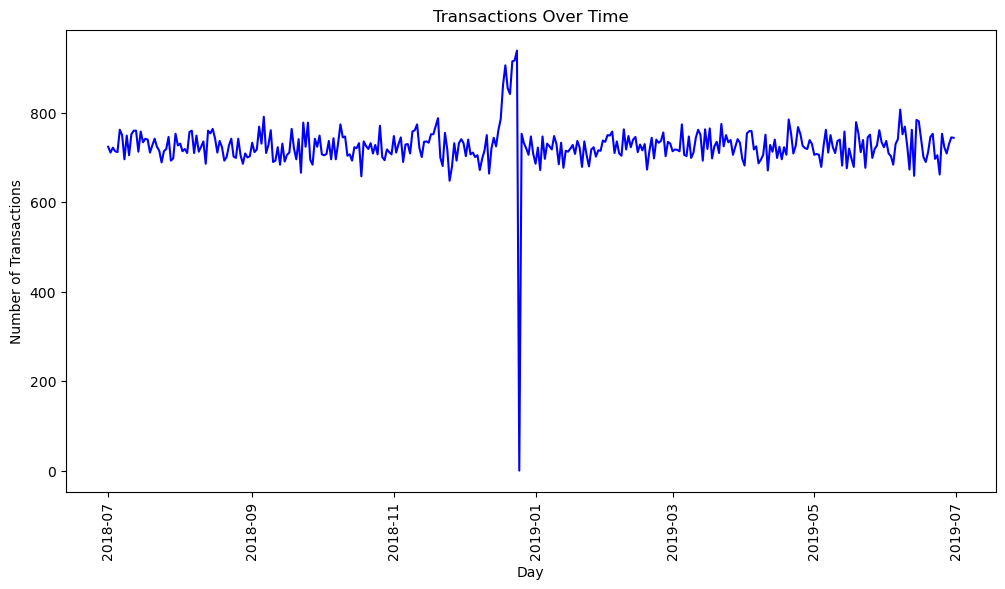

In [19]:
# plot transactions count over time
plt.figure(figsize=(12, 6))
plt.plot(tx_by_day['DATE'], tx_by_day['N'], linestyle='-', marker='', color='b')

# formatting
plt.xlabel("Day")
plt.ylabel("Number of Transactions")
plt.title("Transactions Over Time")
plt.xticks(rotation=90)  # rotate x-axis labels

plt.show()

We can see that there is an increase in purchases in December and a break in late December. Then we zoom in
 on this.

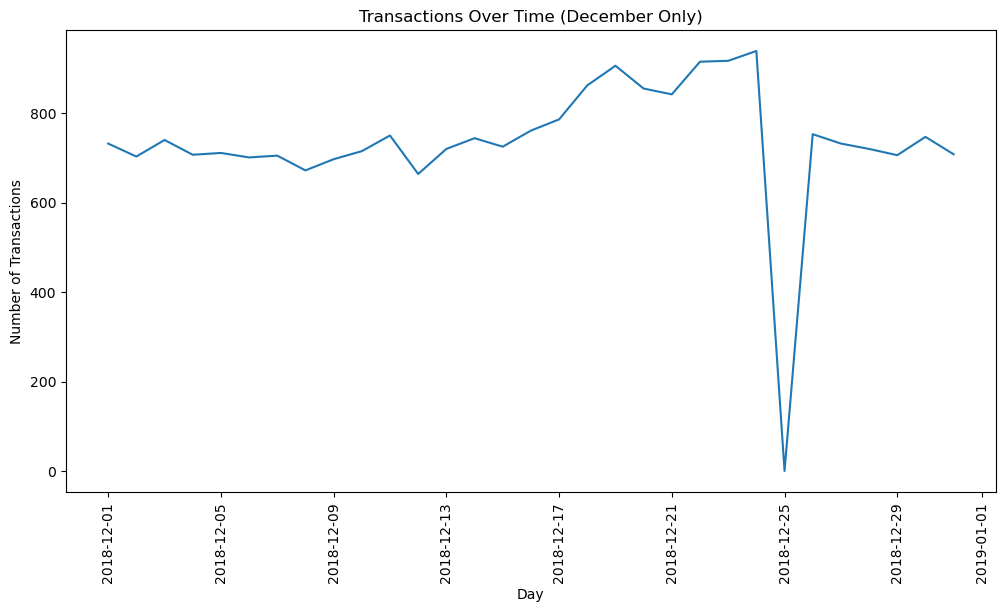

In [20]:
# filter for December only
december_data = tx_by_day[tx_by_day['DATE'].dt.month == 12]

# plot transactions in December
plt.figure(figsize=(12, 6))
sns.lineplot(data=december_data, x='DATE', y='N')

# formatting
plt.xlabel("Day")
plt.ylabel("Number of Transactions")
plt.title("Transactions Over Time (December Only)")
plt.xticks(rotation=90)

plt.show()

 We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on
 Christmas day itself. This is due to shops being closed on Christmas day -- make sense.

5. Feature engineering

5.1 Extract pack size  
It is embedded in 'PROD_NAME' columns and will help analyze purchase behavior. So it should be extracted and listed in a single column.

In [21]:
# extract numeric values from 'PROD_NAME' column
transactions['PACK_SIZE'] = transactions['PROD_NAME'].str.extract('(\d+)')

transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150
...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150


In [22]:
transactions['PACK_SIZE'].info()

<class 'pandas.core.series.Series'>
Index: 264834 entries, 0 to 264835
Series name: PACK_SIZE
Non-Null Count   Dtype 
--------------   ----- 
264834 non-null  object
dtypes: object(1)
memory usage: 4.0+ MB


In [23]:
# convert into int
transactions['PACK_SIZE'] = pd.to_numeric(transactions['PACK_SIZE'], errors = 'coerce')

transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150
...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150


5.2 Extract brand name  
The first word in 'PROD_NAME' column is brand name and should be extracted for further analysis on purchase behavior.

In [24]:
# extract the first word in 'PROD_NAME' column
transactions['BRAND_NAME'] = transactions['PROD_NAME'].str.split().str[0]

# count transactions per brand
brand_counts = transactions.groupby('BRAND_NAME').size().reset_index(name='N')

# Sort in descending order
brand_counts = brand_counts.sort_values(by='N', ascending=False)

print(brand_counts)

    BRAND_NAME      N
12      Kettle  41288
20      Smiths  28860
16    Pringles  25102
6      Doritos  24962
23       Thins  14075
17         RRD  11894
10   Infuzions  11057
27          WW  10320
4         Cobs   9693
24    Tostitos   9471
25    Twisties   9454
15         Old   9324
26    Tyrrells   6442
8        Grain   6272
14     Natural   6050
18         Red   5885
3     Cheezels   4603
1          CCs   4551
28  Woolworths   4437
5       Dorito   3183
11      Infzns   3144
19       Smith   2963
2      Cheetos   2927
21       Snbts   1576
0       Burger   1564
9      GrnWves   1468
22    Sunbites   1432
13         NCC   1419
7       French   1418


 Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red
 Rock Deli chips. So we combine these together.

In [25]:
# create dictionary to map incorrect brand names to correct ones
brand_corrections = {
    "RED": "RRD",
    "SNBTS": "SUNBITES",
    "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS",
    "SMITH": "SMITHS",
    "NCC": "NATURAL",
    "DORITO": "DORITOS",
    "GRAIN": "GRNWVES"
}

# replace incorrect brand names
transactions['BRAND_NAME'] = transactions['BRAND_NAME'].replace(brand_corrections)

transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


In [26]:
# check brand names again
brand_counts_cleaned = transactions.groupby('BRAND_NAME').size().reset_index(name='N')

# sort
brand_counts_cleaned = brand_counts_cleaned.sort_values(by='BRAND_NAME', ascending=True)

brand_counts_cleaned

,BRAND_NAME,N
0,Burger,1564
1,CCs,4551
2,Cheetos,2927
3,Cheezels,4603
4,Cobs,9693
5,Dorito,3183
6,Doritos,24962
7,French,1418
8,Grain,6272
9,GrnWves,1468


5.3 Derive unit price

In [27]:
transactions['UNIT_PRICE'] = transactions['TOT_SALES'] / transactions['PROD_QTY']
transactions['UNIT_PRICE'].fillna(0, inplace=True)

transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,UNIT_PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,4.60
...,...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,5.40
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,4.40
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Doritos,4.40
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Doritos,3.90


### 1.2 Explore on customer data

1. View data structure

In [28]:
customers.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [29]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


From information listed as above:  
-  There are 3 columns and 72636 rows in total, no missing values.  
-  All columns are in correct data type.

In [30]:
customers.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


2. Check duplicate  
Check if there are duplicate customer information.

In [31]:
# check duplicate
duplicate_customers = customers[customers['LYLTY_CARD_NBR'].duplicated(keep=False)]
print(duplicate_customers)

Empty DataFrame
Columns: [LYLTY_CARD_NBR, LIFESTAGE, PREMIUM_CUSTOMER]
Index: []


3. Check 'LIFESTAGE' column

In [32]:
# count occurences of each LIFESTAGE
lifestage_counts = customers.groupby('LIFESTAGE').size().reset_index(name='N')

# sort in descending order
lifestage_counts = lifestage_counts.sort_values(by='N', ascending=False)

lifestage_counts

,LIFESTAGE,N
4,RETIREES,14805
3,OLDER SINGLES/COUPLES,14609
6,YOUNG SINGLES/COUPLES,14441
2,OLDER FAMILIES,9780
5,YOUNG FAMILIES,9178
0,MIDAGE SINGLES/COUPLES,7275
1,NEW FAMILIES,2549


4. Check 'PREMIUM_CUSTOMER' column

In [33]:
# count occurences of each LIFESTAGE
premium_cust_counts = customers.groupby('PREMIUM_CUSTOMER').size().reset_index(name='N')

# sort in descending order
premium_cust_counts = premium_cust_counts.sort_values(by='N', ascending=False)

premium_cust_counts

,PREMIUM_CUSTOMER,N
1,Mainstream,29245
0,Budget,24470
2,Premium,18922


### 1.3 Merge transaction data and customer data

Since the task is to understand customer segment based on purchase history, so those customers with no purchase history are not the focus in this project. In order to remain all transaction data in merged table, here we set transaction data as left table and use left join to merge two tables.

In [34]:
merged_df = pd.merge(transactions, customers, on='LYLTY_CARD_NBR', how='left')
merged_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,UNIT_PRICE,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,3.00,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,2.10,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,1.45,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,3.00,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,4.60,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,5.40,YOUNG SINGLES/COUPLES,Premium
264830,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,4.40,YOUNG SINGLES/COUPLES,Premium
264831,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Doritos,4.40,YOUNG SINGLES/COUPLES,Premium
264832,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Doritos,3.90,YOUNG SINGLES/COUPLES,Premium


In [35]:
# save as a csv file
merged_df.to_csv('data/quantium_da/QVI_merged.csv', index=False)

# 2. Sales Performance Evaluation

## 2.1 Sales Overview

1. Sales distribution among segments

In [37]:
sales_per_seg = merged_df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].sum().reset_index(name='SEG_SALES')
sales_per_seg

,PREMIUM_CUSTOMER,LIFESTAGE,SEG_SALES
0,Budget,MIDAGE SINGLES/COUPLES,35514.80
1,Budget,NEW FAMILIES,21928.45
2,Budget,OLDER FAMILIES,168363.25
3,Budget,OLDER SINGLES/COUPLES,136769.80
4,Budget,RETIREES,113147.80
5,Budget,YOUNG FAMILIES,139345.85
6,Budget,YOUNG SINGLES/COUPLES,61141.60
7,Mainstream,MIDAGE SINGLES/COUPLES,90803.85
8,Mainstream,NEW FAMILIES,17013.90
9,Mainstream,OLDER FAMILIES,103445.55


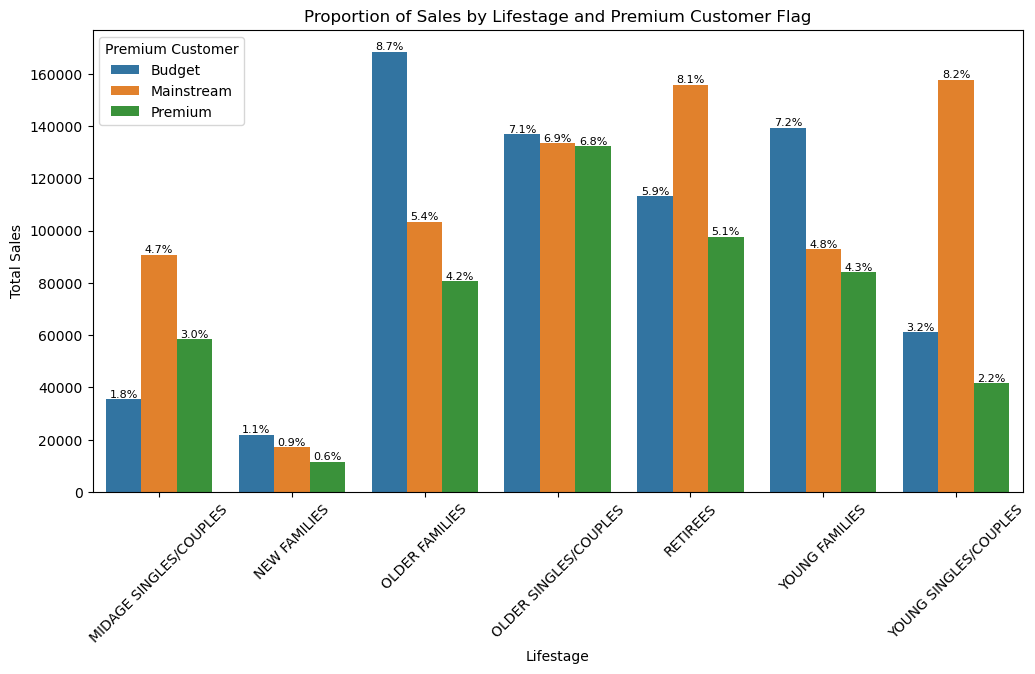

In [55]:
# plot bar chart of sales distribution across lifestage and premium type
# ensure index alignment by resetting index
sales_per_seg = sales_per_seg.reset_index(drop=True)

# calculate proportions correctly within each 'LIFESTAGE' group
sales_per_seg['Percentage'] = sales_per_seg['SEG_SALES'].transform(lambda x: x / x.sum() * 100)

# create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=sales_per_seg, x='LIFESTAGE', y='SEG_SALES', hue='PREMIUM_CUSTOMER')

# add percentage labels
for p, percentage in zip(ax.patches, sales_per_seg['Percentage']):
    height = p.get_height()
    if height > 0:  # avoid division by zero
        ax.text(p.get_x() + p.get_width()/2, height, f"{percentage:.1f}%", 
                ha='center', va='bottom', fontsize=8, color='black')

# formatting
plt.xlabel("Lifestage")
plt.ylabel("Total Sales")
plt.title("Proportion of Sales by Lifestage and Premium Customer Flag")
plt.xticks(rotation=45)
plt.legend(title="Premium Customer")

plt.show()

Findings from the bar chart of sales distribution among segments:  
-   Sales are coming mainly from 'Budget-Older Families', 'Mainstream-Young Singles/Couples', and 'Mainstream-Retirees';  
-  'Older Families' & 'Older Singles/Couples' have the highest sales;  
-  'New Families' have the lowest sales.

## 2.2 Driver 1: Number of Customers

(Driver 1) Check if the higher sales are due to there being more customers who buy chips

1. Number of customers in each segment

In [36]:
# count the number distinct customers in each segment
cust_per_seg = customers.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['LYLTY_CARD_NBR'].count().reset_index(name='CUST_COUNT')
cust_per_seg

,PREMIUM_CUSTOMER,LIFESTAGE,CUST_COUNT
0,Budget,MIDAGE SINGLES/COUPLES,1504
1,Budget,NEW FAMILIES,1112
2,Budget,OLDER FAMILIES,4675
3,Budget,OLDER SINGLES/COUPLES,4929
4,Budget,RETIREES,4454
5,Budget,YOUNG FAMILIES,4017
6,Budget,YOUNG SINGLES/COUPLES,3779
7,Mainstream,MIDAGE SINGLES/COUPLES,3340
8,Mainstream,NEW FAMILIES,849
9,Mainstream,OLDER FAMILIES,2831


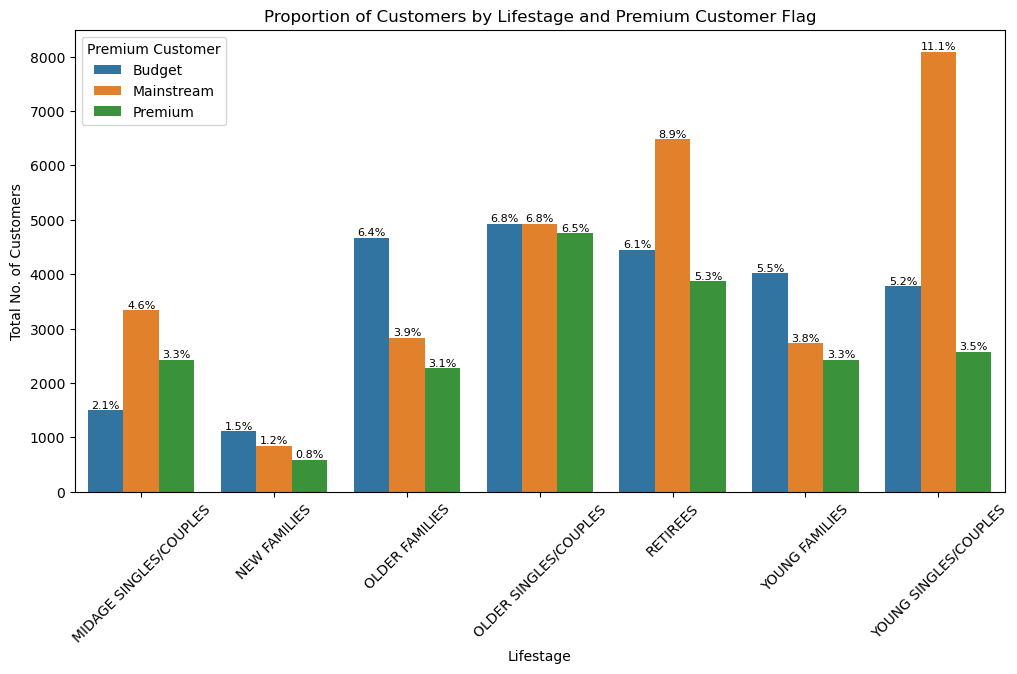

In [56]:
# plot bar chart of number of customers across lifestage and premium type
# ensure index alignment by resetting index
cust_per_seg = cust_per_seg.reset_index(drop=True)

# calculate proportions correctly within each 'LIFESTAGE' group
cust_per_seg['Percentage'] = cust_per_seg['CUST_COUNT'].transform(lambda x: x / x.sum() * 100)

# create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=cust_per_seg, x='LIFESTAGE', y='CUST_COUNT', hue='PREMIUM_CUSTOMER')

# add percentage labels
for p, percentage in zip(ax.patches, cust_per_seg['Percentage']):
    height = p.get_height()
    if height > 0:  # avoid division by zero
        ax.text(p.get_x() + p.get_width()/2, height, f"{percentage:.1f}%", 
                ha='center', va='bottom', fontsize=8, color='black')

# formatting
plt.xlabel("Lifestage")
plt.ylabel("Total No. of Customers")
plt.title("Proportion of Customers by Lifestage and Premium Customer Flag")
plt.xticks(rotation=45)
plt.legend(title="Premium Customer")

plt.show()

Findings: There are more 'Mainstream-Young Singles/Couples' and 'Mainstream-Retirees' who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the 'Budget-Older Families' segment.

## 2.3 Driver 2: Units bought by per customer

(Driver 2) Check if the higher sales are due to there being more units of chips bought by per customer

1. Average number of units per customer per segment

In [58]:
# calculate sum of quantity and count of distinct customers per segment
unit_per_cust = merged_df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).agg(
    AVG_UNIT=('PROD_QTY', 'sum'),
    TOTAL_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique')  # count distinct customers
).reset_index()

# calculate the average units per customer
unit_per_cust['AVG_QTY'] = unit_per_cust['AVG_UNIT'] / unit_per_cust['TOTAL_CUSTOMERS']

# drop the extra columns
unit_per_cust = unit_per_cust.drop(columns=['TOTAL_CUSTOMERS','AVG_UNIT'])

unit_per_cust

,PREMIUM_CUSTOMER,LIFESTAGE,AVG_QTY
0,Budget,MIDAGE SINGLES/COUPLES,6.313830
1,Budget,NEW FAMILIES,5.009892
2,Budget,OLDER FAMILIES,9.639572
3,Budget,OLDER SINGLES/COUPLES,7.145466
4,Budget,RETIREES,6.458015
5,Budget,YOUNG FAMILIES,9.238486
6,Budget,YOUNG SINGLES/COUPLES,4.411485
7,Mainstream,MIDAGE SINGLES/COUPLES,6.796108
8,Mainstream,NEW FAMILIES,5.087161
9,Mainstream,OLDER FAMILIES,9.804309


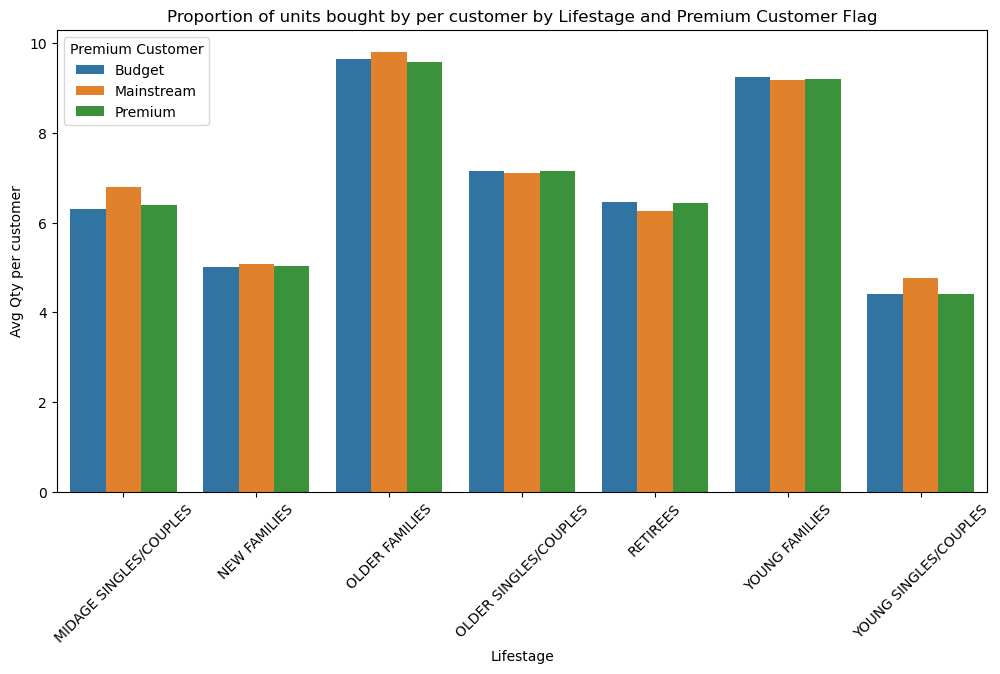

In [59]:
# plot bar chart of units bought by per customer across lifestage and premium type
# create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=unit_per_cust, x='LIFESTAGE', y='AVG_QTY', hue='PREMIUM_CUSTOMER')

# formatting
plt.xlabel("Lifestage")
plt.ylabel("Avg Qty per customer")
plt.title("Proportion of units bought by per customer by Lifestage and Premium Customer Flag")
plt.xticks(rotation=45)
plt.legend(title="Premium Customer")

plt.show()

Findings:  Older families and young families in general buy more chips per customer.

## 2.4 Driver 3: Unit price

(Driver 3) Check if the higher sales are due to there being higher average price per unit chips bought for each customer segment.

1. Average unit price per segment

In [60]:
# calculate sum of quantity and sum of total sales per segment
unit_price = merged_df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).agg(
    SUM_QTY=('PROD_QTY', 'sum'),
    SUM_SALES=('TOT_SALES', 'sum')  
).reset_index()

# calculate the average unit price per segment
unit_price['UNIT_PRICE'] = unit_price['SUM_SALES'] / unit_price['SUM_QTY']

# drop the extra columns
unit_price = unit_price.drop(columns=['SUM_SALES','SUM_QTY'])

unit_price

,PREMIUM_CUSTOMER,LIFESTAGE,UNIT_PRICE
0,Budget,MIDAGE SINGLES/COUPLES,3.739975
1,Budget,NEW FAMILIES,3.936178
2,Budget,OLDER FAMILIES,3.736009
3,Budget,OLDER SINGLES/COUPLES,3.883299
4,Budget,RETIREES,3.933660
5,Budget,YOUNG FAMILIES,3.754840
6,Budget,YOUNG SINGLES/COUPLES,3.667542
7,Mainstream,MIDAGE SINGLES/COUPLES,4.000346
8,Mainstream,NEW FAMILIES,3.939315
9,Mainstream,OLDER FAMILIES,3.726962


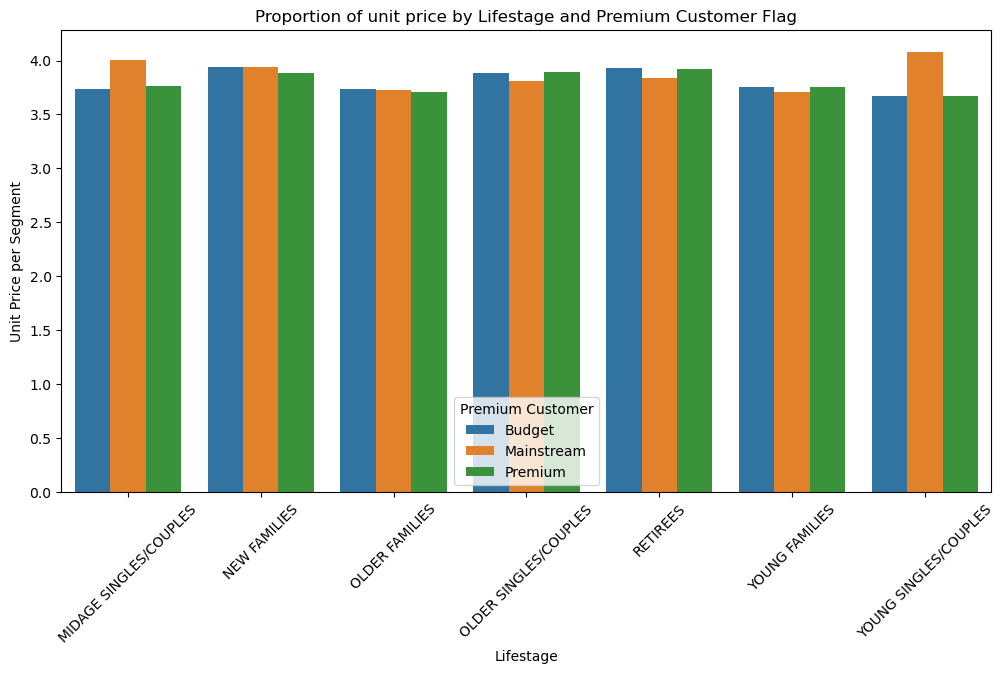

In [61]:
# plot bar chart of unit price across lifestage and premium type
# create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=unit_price, x='LIFESTAGE', y='UNIT_PRICE', hue='PREMIUM_CUSTOMER')

# formatting
plt.xlabel("Lifestage")
plt.ylabel("Unit Price per Segment")
plt.title("Proportion of unit price by Lifestage and Premium Customer Flag")
plt.xticks(rotation=45)
plt.legend(title="Premium Customer")

plt.show()

Findings: 'Mainstream Midage and Young Singles and Couples' are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to
 buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer 'Premium Midage and Young Singles and Couples'
 buying chips compared to their mainstream counterparts.

2. Statistical test on difference b/w 'Mainstream' and other segments  
The difference in average price per unit may appear small, but it could still be statistically significant. Even small differences can be important in large datasets because a small per-unit difference can accumulate into a large total impact. A statistical test helps determine whether this observed difference is likely due to actual purchasing behavior patterns or just random variations in the data.

In [62]:
# calculate price per unit
merged_df['UNIT_PRICE'] = merged_df['TOT_SALES'] / merged_df['PROD_QTY']

# define groups for t-test
mainstream_group = merged_df[
    (merged_df['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) & 
    (merged_df['PREMIUM_CUSTOMER'] == "Mainstream")
]['UNIT_PRICE']

non_mainstream_group = merged_df[
    (merged_df['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) & 
    (merged_df['PREMIUM_CUSTOMER'] != "Mainstream")
]['UNIT_PRICE']

# perform a one-tailed independent t-test (greater alternative hypothesis)
t_stat, p_value = ttest_ind(mainstream_group, non_mainstream_group, alternative='greater', equal_var=False)

print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

T-Statistic: 40.6099, P-Value: 0.0000


Findings: The t-test results in a p-value < 2.2e-16, i.e. the unit price for mainstream, young and mid-age singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.

# 3. Target Customer Identification and Preference Analysis

1. Mainstream, Young Singles/Couples

## 3.1 Preference analysis on brand of chips

Deep dive 1: Do they tend to buy a particular brand of chips?  
Brand Affinity Analysis: To analyze customer preferences by identifying which brands are more preferred by a specific segment compared to the rest. It provides actionable insights for marketing & product positioning.

In [63]:
# define target segment and other segments
segment1 = merged_df[(merged_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (merged_df['PREMIUM_CUSTOMER'] == "Mainstream")]
other = merged_df[~((merged_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (merged_df['PREMIUM_CUSTOMER'] == "Mainstream"))]

# calculate total product quantity for each group
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# compute brand preferences within each group
quantity_segment1_by_brand = (
    segment1.groupby('BRAND_NAME')['PROD_QTY']
    .sum()
    .div(quantity_segment1)  # normalize by total quantity
    .reset_index()
    .rename(columns={'PROD_QTY': 'targetSegment'})
)

quantity_other_by_brand = (
    other.groupby('BRAND_NAME')['PROD_QTY']
    .sum()
    .div(quantity_other)  # normalize by total quantity
    .reset_index()
    .rename(columns={'PROD_QTY': 'other'})
)

# compare brand affinity
brand_proportions = quantity_segment1_by_brand.merge(quantity_other_by_brand, on='BRAND_NAME')
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']

# rank brands by affinity
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

brand_proportions

,BRAND_NAME,targetSegment,other,affinityToBrand
5,Dorito,0.014729,0.011886,1.239159
26,Tyrrells,0.029587,0.023933,1.236235
25,Twisties,0.043306,0.035283,1.227401
12,Kettle,0.185649,0.154216,1.203823
24,Tostitos,0.042581,0.035377,1.203638
15,Old,0.041598,0.034753,1.196958
11,Infzns,0.014004,0.011712,1.195663
16,Pringles,0.111980,0.093743,1.194536
8,Grain,0.027309,0.023401,1.167002
6,Doritos,0.108149,0.093391,1.158015


Findings:  
-  'Mainstream Young Singles/Couples' are 23% (line no.5) more likely to purchase Tyrrells chips compared to the
 rest of the population  
 -  'Mainstream Young Singles/Couples' are 56% (line no.0) less likely to purchase Burger Rings compared to the rest
 of the population

## 3.2 Preference analysis on pack size

Deep dive 2: Do they tend to buy larger packs of chips?

In [64]:
# calculate total product quantity for each group
quantity_segment1_by_pack = (
    segment1.groupby('PACK_SIZE')['PROD_QTY']
    .sum()
    .div(quantity_segment1)  # normalize by total quantity
    .reset_index()
    .rename(columns={'PROD_QTY': 'targetSegment'})
)

quantity_other_by_pack = (
    other.groupby('PACK_SIZE')['PROD_QTY']
    .sum()
    .div(quantity_other)  # normalize by total quantity
    .reset_index()
    .rename(columns={'PROD_QTY': 'other'})
)

# merge pack size proportions
pack_proportions = quantity_segment1_by_pack.merge(quantity_other_by_pack, on='PACK_SIZE')

# calculate affinity to pack size
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']

# sort by affinity descending
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)

print(pack_proportions)

    PACK_SIZE  targetSegment     other  affinityToPack
17        270       0.029846  0.023377        1.276694
20        380       0.030156  0.023832        1.265361
19        330       0.057465  0.046727        1.229814
4         134       0.111980  0.093743        1.194536
2         110       0.099658  0.083642        1.191482
14        210       0.027309  0.023401        1.167002
5         135       0.013849  0.012180        1.136997
16        250       0.013460  0.011905        1.130611
9         170       0.075740  0.075440        1.003980
18        300       0.054954  0.057263        0.959679
10        175       0.239102  0.251517        0.950641
6         150       0.155130  0.163446        0.949122
8         165       0.052185  0.058004        0.899681
12        190       0.007015  0.011590        0.605256
11        180       0.003365  0.005651        0.595459
7         160       0.006005  0.011526        0.521046
1          90       0.005954  0.011719        0.508043
3         

Findings: It looks like 'Mainstream Young Singles/Couples' are 27% (line no.17) more likely to purchase a 270g pack of chips com
pared to the rest of the population but let's dive into what brands sell this pack size.

In [66]:
filtered_pack_size = merged_df[merged_df['PACK_SIZE'] == 270]
unique_prod_names = filtered_pack_size['PROD_NAME'].unique()

unique_prod_names

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

Findings: Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of purchasing Twisties.

## 3.3 Conclusion and Recommendation

1. Sales Indicators

Sales have mainly been due to 'Budget-Older Families', 'Mainstream-Young Singles/Couples', and 'Mainstream-Retirees' shoppers.  
-  We found that the high spend in chips for 'Mainstream Young Singles/Couples' and 'Mainstream Re
tirees' is due to there being more of them than other buyers.  
-  'Mainstream, Midage and Young Singles and Couples' are also more likely to pay more per packet of chips.  
This is indicative of impulse buying behaviour.

2. Customer Preference

'Mainstream Young Singles and Couples' are 23% more likely to purchase Tyrrells chips compared to the rest of the population. The Category Manager may want to increase the category's performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments where young singles and couples frequent more often to increase visibilty and impulse behaviour.

# 4. Recommendation Impact Assessment

## 4.1 Identify control stores

1. Information on <b>Trial Stores</b>  
-  Trial stores: store 77, 86, 88  
-  Trial period: Feb 2019 - Apr 2019

2. Algorithm of selecting <b>Control Stores</b>  
-  <u>Business period</u>: stores that have a full observation period before the trial (e.g. full 12-month pre-trial period), providing a stable and reliable dataset for meaningful comparisons.  
-  <u>Store span</u>: <u>all stores which meet all criteria, not just trial stores' historical data, ensuring to separate trial effects from external factors.</u>   
    -  e.g. Store 77 saw a 20% increase in sales during trial period, we can't tell it was due to the trial, or because of a general market trend. If similar control stores (not trial stores) did not see this increase during trial period, then we can conclude the trial had an impact. But if control stores (not trial stores) also saw a 20% increase during trial period, then we know that the increase was likely due to external factors.  
-  <u>Performance</u>: stores that have similar performance with trial stores during pre-trial period.  
    -  Monthly overall sales revenue  
    -  Monthly number of customers  
    -  Monthly number of transactions per customer  
    -  Monthly quantity of chips per transaction  
    -  Monthly unit price

In [78]:
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], errors='coerce')
merged_df['YEARMONTH'] = merged_df['DATE'].dt.year * 100 + merged_df['DATE'].dt.month

merged_df.info()
merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              264834 non-null  datetime64[ns]
 1   STORE_NBR         264834 non-null  int64         
 2   LYLTY_CARD_NBR    264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND_NAME        264834 non-null  object        
 10  UNIT_PRICE        264834 non-null  float64       
 11  LIFESTAGE         264834 non-null  object        
 12  PREMIUM_CUSTOMER  264834 non-null  object        
 13  YEARMONTH         264834 non-null  int32         
dtypes: d

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,UNIT_PRICE,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,3.00,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,2.10,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,1.45,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,3.00,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,4.60,MIDAGE SINGLES/COUPLES,Budget,201808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,5.40,YOUNG SINGLES/COUPLES,Premium,201903
264830,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,4.40,YOUNG SINGLES/COUPLES,Premium,201808
264831,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Doritos,4.40,YOUNG SINGLES/COUPLES,Premium,201811
264832,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Doritos,3.90,YOUNG SINGLES/COUPLES,Premium,201812


In [79]:
# add a column for YearMonth in YYYYMM format
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], errors='coerce')
merged_df['YEARMONTH'] = merged_df['DATE'].dt.year * 100 + merged_df['DATE'].dt.month

# define the measure calculations
measure_over_time = (
    merged_df.groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),  # unique customers per store-month
        nTxnPerCust=('TXN_ID', lambda x: x.nunique() / merged_df.loc[merged_df['TXN_ID'].isin(x), 'LYLTY_CARD_NBR'].nunique()),
        nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / x.nunique()),  
        avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / merged_df.loc[merged_df['TOT_SALES'].isin(x), 'PROD_QTY'].sum())
    )
    .reset_index()
    .sort_values(by=['STORE_NBR', 'YEARMONTH'])
)

# get stores that have observations for all 12 months
stores_with_full_obs = (
    measure_over_time.groupby('STORE_NBR')
    .filter(lambda x: len(x) == 12)['STORE_NBR']
    .unique()
)

# filter to the pre-trial period and stores with full observation periods
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) & (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))
]

pre_trial_measures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,31.0,0.001138
1,1,201808,176.1,42,1.023810,18.0,0.000965
2,1,201809,278.8,59,1.050847,37.5,0.000943
3,1,201810,188.1,44,1.022727,29.0,0.000598
4,1,201811,192.6,46,1.021739,28.5,0.000846
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,35.5,0.000917
3160,272,201810,430.6,44,1.136364,49.5,0.001322
3161,272,201811,376.2,41,1.097561,43.5,0.001248
3162,272,201812,403.9,47,1.000000,44.5,0.001207


In [80]:
pre_trial_measures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 3163
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        1820 non-null   int64  
 1   YEARMONTH        1820 non-null   int32  
 2   totSales         1820 non-null   float64
 3   nCustomers       1820 non-null   int64  
 4   nTxnPerCust      1820 non-null   float64
 5   nChipsPerTxn     1820 non-null   float64
 6   avgPricePerUnit  1820 non-null   float64
dtypes: float64(4), int32(1), int64(2)
memory usage: 106.6 KB


3. Check similarity of each potential control store to the trial store

3.1 Correlation-based similarity (Correlation)  
-  <u>Definition</u>: Measures the linear relationship between two variables.  
-  <u>Purpose</u>: Identifies how strongly two variables move together.  
-  <u>Scale</u>: Ranges from -1 to 1.  
    -  1: Perfect positive correlation  
    -  -1: Perfect negative correlation  
    -  0: No correlation  
-  <u>Sensitivity to Scale</u>: Affected by scaling of data (e.g., if all values are doubled, correlation remains unchanged).  
-  <u>Application in Store Matching</u>: Determines if a control store’s trend matches the trial store’s trend.(trend matching: e.g. If both stores have sales increasing or decreasing together, even with different amounts, they will have a high correlation.)  
-  <u>Use Case in Trail Analysis</u>: Identifies stores with similar patterns over time.

In [81]:
def calculate_correlation(input_table, metric_col, store_comparison):
    """
    Function to calculate correlation between a reference store and all other stores.

    Parameters:
    input_table (DataFrame): The dataset containing store numbers and metric values.(potential control store numbers)
    metric_col (str): Column name containing the metric for correlation.
    store_comparison (int or str): The reference store number.(trial store numbers)

    Returns:
    DataFrame: A DataFrame containing Store1, Store2, and their correlation measure.
    """

    # extract unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()

    # initialize an empty DataFrame to store results
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])

    # iterate through each store and calculate correlation
    for i in store_numbers:
        # compute correlation only if store_comparison is different from store i
        if i != store_comparison:
            store1_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col]
            store2_data = input_table[input_table['STORE_NBR'] == i][metric_col]
            
            # ensure data is aligned and non-empty before calculating correlation
            if len(store1_data) >= 1 and len(store2_data) >= 1:
                correlation = np.corrcoef(store1_data, store2_data)[0, 1]
                calculated_measure = pd.DataFrame([[store_comparison, i, correlation]],
                                                  columns=['Store1', 'Store2', 'corr_measure'])
                # append to the results table
                calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)

    return calc_corr_table

3.2 Magnitude-based similarity (Standardized Magnitude Distance)  
-  <u>Definition</u>: Measures the absolute difference between two values, scaled between 0 and 1.  
-  <u>Purpose</u>: Measures the absolute deviation between a store's metric and a control store’s metric.  
-  <u>Scale</u>: Always between 0 and 1.  
    -  0: Minimum difference  
    -  1: Maximum difference  
-  <u>Sensitivity to Scale</u>: Accounts for scale differences by normalizing distances.  
-  <u>Application in Store Matching</u>: Ensures that the absolute difference in metrics between stores is minimized.(e.g. If Store A has total sales of 50,000 and Store B has 52,000, the absolute difference is 2,000. If Store C has 70,000 sales, the absolute difference is 20,000. Standardized magnitude distance ensures we prioritize stores with similar sales levels, not just similar trends.)  
-  <u>Use Case in Trail Analysis</u>: Filters out stores with high absolute deviations, even if they show some correlation.

In [82]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Function to calculate standardized magnitude distance for a measure between a trial store and control stores.

    Parameters:
    input_table (DataFrame): The dataset containing store numbers and metric values.(potential control store numbers)
    metric_col (str): Column name containing the metric for correlation.
    store_comparison (int or str): The reference store number.(trial store numbers)

    Returns:
    DataFrame: A DataFrame containing Store1, Store2, YEARMONTH and their measure.
    """

    # creates an empty table to store results
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "YEARMONTH", "measure"])
    
    # extracts unique store numbers
    store_numbers = input_table["STORE_NBR"].unique()
    
    # loops through control stores and calculates absolute differences in metric
    for i in store_numbers:
        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * len(input_table[input_table["STORE_NBR"] == store_comparison]),
            "Store2": [i] * len(input_table[input_table["STORE_NBR"] == store_comparison]),
            "YEARMONTH": input_table[input_table["STORE_NBR"] == store_comparison]["YEARMONTH"].values,
            "measure": abs(
                input_table[input_table["STORE_NBR"] == store_comparison][metric_col].values - 
                input_table[input_table["STORE_NBR"] == i][metric_col].values
            )
        })
    
        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
        """
        calculate abs distance b/t a given control store and all other trail stores. 
        This is done by iterating through each store and computing the absolute difference in a given metric 
        (metric_col) over different YEARMONTH periods.
        """
    
    # normalize distance between 0 and 1 (reference table based on trial store per month)
    min_max_dist = calc_dist_table.groupby(["Store1", "YEARMONTH"])["measure"].agg(["min", "max"]).reset_index()
    min_max_dist.columns = ["Store1", "YEARMONTH", "minDist", "maxDist"]
    
    # merge and compute standardized magnitude distance
    dist_table = calc_dist_table.merge(min_max_dist, on=["Store1", "YEARMONTH"])
    dist_table["magnitudeMeasure"] = 1 - (dist_table["measure"] - dist_table["minDist"]) / (dist_table["maxDist"] - dist_table["minDist"])
    
    # computes the average magnitude distance over time for each store pair (each pair get one avg measure)
    final_dist_table = dist_table.groupby(["Store1", "Store2"])["magnitudeMeasure"].mean().reset_index()
    final_dist_table.rename(columns={"magnitudeMeasure": "mag_measure"}, inplace=True)
    
    return final_dist_table

4. Find the control store  

4.1 Compute each similarity score in terms of monthly total sales in dollar amounts and monthly number of customers

In [83]:
# define trial store
trial_store = 77

# compute correlation-based similarity
corr_nSales = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

# compute magnitude-based similarity
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

4.2 Combine all the scores to create a composite score to rank on

In [84]:
# define weight
corr_weight = 0.5

# compute combined similarity scores
score_nSales = corr_nSales.merge(magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = (
    score_nSales["corr_measure"] * corr_weight + score_nSales["mag_measure"] * (1 - corr_weight)
)

score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = (
    score_nCustomers["corr_measure"] * corr_weight + score_nCustomers["mag_measure"] * (1 - corr_weight)
)

# combine the two scores
score_Control = score_nSales.merge(score_nCustomers, on=["Store1", "Store2"])
score_Control["finalControlScore"] = (
    score_Control["scoreNSales"] * 0.5 + score_Control["scoreNCust"] * 0.5
)

4.3 Select the final control store: The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [91]:
# select control store for the trial store (excluding itself)
control_store = (
    score_Control[score_Control["Store1"] == trial_store]
    .sort_values(by="finalControlScore", ascending=False)
    .iloc[0]["Store2"]  # select the second highest store (excluding trial store itself)
)

print(control_store)

233


5. Visually check if the drivers are indeed similar in the period before the trial

In [92]:
# assign store type labels
measure_over_time_sales = measure_over_time
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else 
              "Control" if x == control_store else 
              "Other stores"
)

measure_over_time_custs = measure_over_time
measure_over_time_custs["Store_type"] = measure_over_time_custs["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else 
              "Control" if x == control_store else 
              "Other stores"
)

# grouping by year-month and store type
pastSales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"], as_index=False)["totSales"].mean()
pastCustomers = measure_over_time_custs.groupby(["YEARMONTH", "Store_type"], as_index=False)["nCustomers"].mean()

# convert YEARMONTH to datetime format
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str), format="%Y%m"
)
pastCustomers["TransactionMonth"] = pd.to_datetime(
    pastCustomers["YEARMONTH"].astype(str), format="%Y%m"
)

# filter data before March 2019
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]
pastCustomers = pastCustomers[pastCustomers["YEARMONTH"] < 201903]

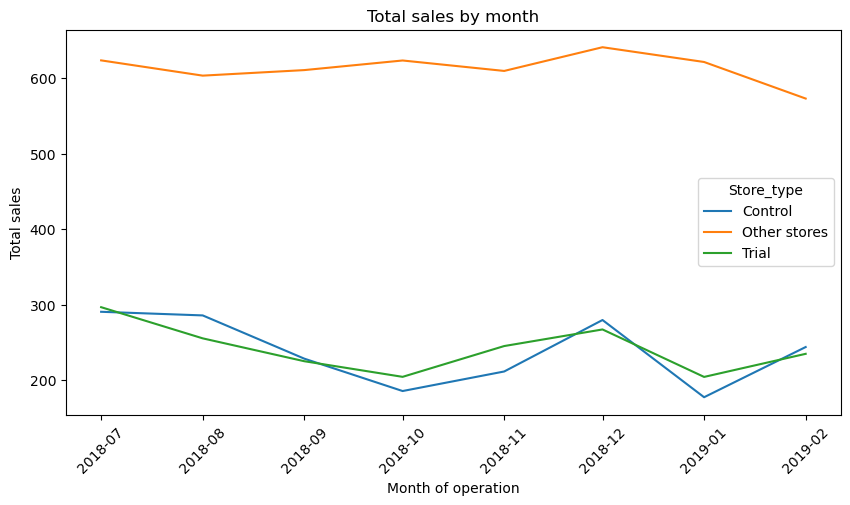

In [93]:
# plot sales trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=pastSales, x="TransactionMonth", y="totSales", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.xticks(rotation=45)
plt.show()

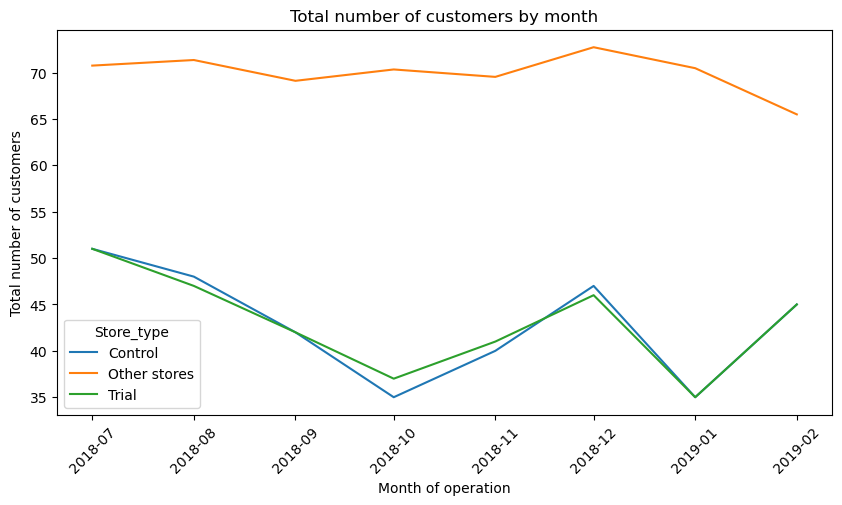

In [94]:
# plot customer trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=pastCustomers, x="TransactionMonth", y="nCustomers", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.xticks(rotation=45)
plt.show()

Findings: the two drivers (total sales and number of customers) are indeed similar in the period before the trial.

## 4.2 Assess on Trial Store No.77

### 4.2.1 Assess on Trial Store No.77 in terms of total sales

1. Scale Control Store sales to match Trial Store sales during pre-trial period  
-  Similarity in trends (correlation & magnitude distance) does not mean equal absolute sales levels. Even if the control store follows the same trends as the trial store (i.e., similar fluctuations over time), their absolute sales numbers may still be different. Scaling Ensures a Fair Baseline for Comparison.  
-  Scaling does not change the fundamental properties of the control store because it only adjusts the absolute sales numbers, not the trends or patterns.  
-  Scaling the control store ensures that its **absolute sales amount** before the trial period is the **same** as the trial store by multiplying its sales by a **constant factor**. This adjustment **removes pre-existing differences** and helps isolate the impact of the trial.

In [95]:
# compute scaling factor
scaling_factor_for_control_sales = (
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "totSales"
    ].sum() /
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "totSales"
    ].sum()
) # one factor for each store pair

# apply the scaling factor to control store's sales in each month
measure_over_time_sales = measure_over_time.copy()

measure_over_time_sales.loc[
    measure_over_time_sales["STORE_NBR"] == control_store, "controlSales"
] = measure_over_time_sales["totSales"] * scaling_factor_for_control_sales

In [97]:
scaling_factor_for_control_sales

1.023617303289553

In [98]:
measure_over_time_sales[measure_over_time_sales["STORE_NBR"] == 233]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlSales
2699,233,201807,290.7,51,1.058824,44.000000,0.000844,Control,297.565550
2700,233,201808,285.9,48,1.041667,16.000000,0.000747,Control,292.652187
2701,233,201809,228.6,42,1.071429,35.000000,0.000689,Control,233.998916
2702,233,201810,185.7,35,1.028571,28.000000,0.000668,Control,190.085733
2703,233,201811,211.6,40,1.025000,31.000000,0.000573,Control,216.597421
2704,233,201812,279.8,47,1.063830,37.500000,0.000787,Control,286.408121
2705,233,201901,177.5,35,1.000000,23.500000,0.000782,Control,181.692071
2706,233,201902,244.0,45,1.044444,35.000000,0.000638,Control,249.762622
2707,233,201903,199.1,40,1.025000,29.500000,0.000642,Control,203.802205
2708,233,201904,158.6,30,1.066667,23.000000,0.000475,Control,162.345704


2. Scale Control Store sales to match Trial Store sales during trial period  
-  Multiply the original control sales in trial period by the constant (scaling factor) found in Step 1, eliminating pre-existing external influences.  
-  Calculate the percentage difference between the scaled control store and trial store sales during the trial period.

In [100]:
percentage_diff_sales = pd.merge(
    measure_over_time_sales.loc[measure_over_time_sales["STORE_NBR"] == control_store, ["YEARMONTH", "controlSales"]],
    measure_over_time_sales.loc[measure_over_time_sales["STORE_NBR"] == trial_store, ["YEARMONTH", "totSales"]],
    on="YEARMONTH"
)

percentage_diff_sales["percentageDiff"] = np.abs(percentage_diff_sales["controlSales"] - percentage_diff_sales["totSales"]) / percentage_diff_sales["controlSales"]

percentage_diff_sales

,YEARMONTH,controlSales,totSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


3. Assess statistical significance  
-  Compare the differences b/w Trial Store and Scaled Control Store during the trial period and the pre-trial period.  
-  If the difference observed in the trial period is significantly higher than pre-trial fluctuations, the trial had an effect.  
-  Use a t-test to check if the difference is statistically significant.  
    -  one-sample one-side t-test: the sample is the percentage difference in the trial period, the pre-trial period is used to estimate the standard deviation, but it is not a separate sample being compared. The test is to check if there is significant increase, not testing for a decrease in sales, meaning we are only considering the upper tail.
    -  Confidence level: 95%  
    -  degree of freedom: 6 (=number of months in pre-trial period - 1)

In [105]:
# calculate the std of pre-trial period
std_dev = percentage_diff_sales.loc[percentage_diff_sales["YEARMONTH"] < 201902, "percentageDiff"].std()
degrees_of_freedom = 6

# calculate t-value
percentage_diff_sales["tValue"] = (percentage_diff_sales["percentageDiff"] - 0) / std_dev
percentage_diff_sales["TransactionMonth"] = pd.to_datetime(
    percentage_diff_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# focus on the t-value in trial period
t_values_trial_period_sales = percentage_diff_sales[
    (percentage_diff_sales["YEARMONTH"] < 201905) & (percentage_diff_sales["YEARMONTH"] > 201901)
][["TransactionMonth", "tValue"]]

t_values_trial_period_sales

,TransactionMonth,tValue
7,2019-02-01,1.183534
8,2019-03-01,7.339116
9,2019-04-01,12.476373


In [107]:
# find the 95th percentile of the t-distribution
t_threshold = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile t-value: {t_threshold}")

95th percentile t-value: 1.9431802803927816


4. Visualize Sales Data Over Time

In [108]:
measure_over_time_sales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlSales
0,1,201807,206.9,49,1.061224,31.0,0.001138,Other stores,NaN
1,1,201808,176.1,42,1.023810,18.0,0.000965,Other stores,NaN
2,1,201809,278.8,59,1.050847,37.5,0.000943,Other stores,NaN
3,1,201810,188.1,44,1.022727,29.0,0.000598,Other stores,NaN
4,1,201811,192.6,46,1.021739,28.5,0.000846,Other stores,NaN
...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,45.5,0.001267,Other stores,NaN
3165,272,201903,442.3,50,1.060000,50.5,0.001352,Other stores,NaN
3166,272,201904,445.1,54,1.018519,52.5,0.001321,Other stores,NaN
3167,272,201905,314.6,34,1.176471,35.5,0.000961,Other stores,NaN


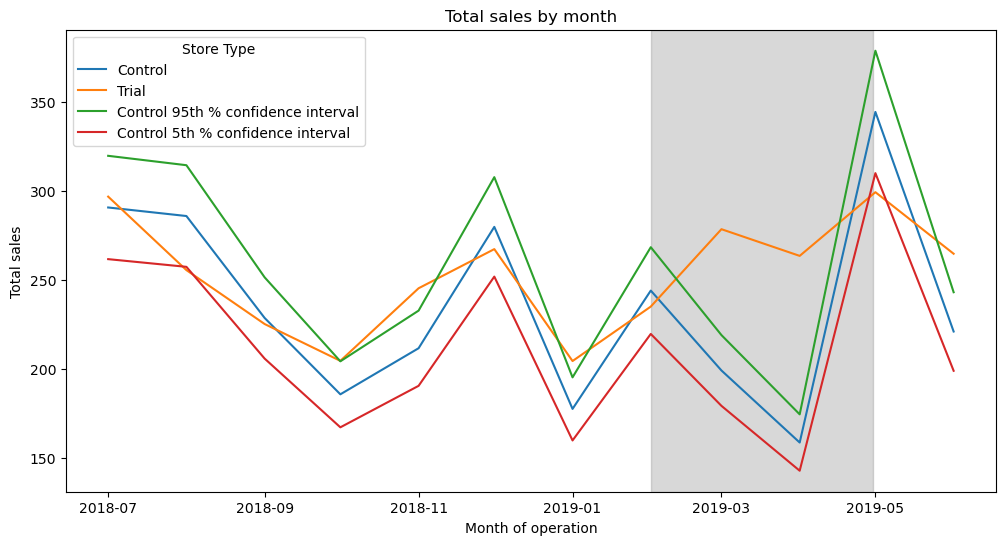

In [110]:
# aggregate sales by year-month and store type
past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"])["totSales"].mean().reset_index()

# convert YEARMONTH to datetime
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# filter for trial and control stores
past_sales = past_sales[past_sales["Store_type"].isin(["Trial", "Control"])]

# compute 95th and 5th percentiles for control store
past_sales_controls_95 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_95["totSales"] = past_sales_controls_95["totSales"] * (1 + std_dev * 2)
past_sales_controls_95["Store_type"] = "Control 95th % confidence interval"

past_sales_controls_5 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_5["totSales"] = past_sales_controls_5["totSales"] * (1 - std_dev * 2)
past_sales_controls_5["Store_type"] = "Control 5th % confidence interval"

# combine all datasets for visualization
trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])

# plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type")

# highlight the trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3)

# Labels
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend(title="Store Type")
plt.show()

Findings:  
-  Before the Trial (Jul 2018 - Jan 2019):  
    -  The trial store and control store follow a similar trend.  
    -  The trial store's sales remain within the control store's confidence interval.  
-  During the Trial Period (Feb 2019 - Apr 2019):  
    -  The trial store's sales exceed the 95th percentile confidence interval in two out of three trial months.  
    -  This means the sales increase in the trial store is statistically significant, suggesting the marketing campaign or intervention had a real impact beyond normal fluctuations.  

Conclusions:  
-  The intervention (e.g., a marketing campaign) had a measurable impact:  
    -  Since the trial store exceeded the expected range (crossed above the 95th percentile), it indicates a positive uplift in sales.  
-  External factors are unlikely to be the reason:  
    -  The control store’s confidence interval accounts for normal sales variations.  
    -  The fact that the trial store went outside this range suggests that the changes are not due to external factors (e.g., seasonality, economic shifts) but rather due to the trial intervention itself.  
-  The intervention led to an increase in total sales during March and April 2019.

### 4.2.2 Assess on Trial Store No.77 in terms of number of customers

1. Scale Control Store customers to match Trial Store customers during pre-trial period

In [111]:
# compute scaling factor
scaling_factor_for_control_custs = (
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "nCustomers"
    ].sum() /
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "nCustomers"
    ].sum()
) # one factor for each store pair

# apply the scaling factor to control store's sales in each month
measure_over_time_custs = measure_over_time.copy()

measure_over_time_custs.loc[
    measure_over_time_custs["STORE_NBR"] == control_store, "controlCusts"
] = measure_over_time_custs["nCustomers"] * scaling_factor_for_control_custs

In [112]:
scaling_factor_for_control_custs

1.0033557046979866

In [135]:
measure_over_time_custs[measure_over_time_custs["STORE_NBR"] == 233]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlCusts
2699,233,201807,290.7,51,1.058824,44.000000,0.000844,Control,51.171141
2700,233,201808,285.9,48,1.041667,16.000000,0.000747,Control,48.161074
2701,233,201809,228.6,42,1.071429,35.000000,0.000689,Control,42.140940
2702,233,201810,185.7,35,1.028571,28.000000,0.000668,Control,35.117450
2703,233,201811,211.6,40,1.025000,31.000000,0.000573,Control,40.134228
2704,233,201812,279.8,47,1.063830,37.500000,0.000787,Control,47.157718
2705,233,201901,177.5,35,1.000000,23.500000,0.000782,Control,35.117450
2706,233,201902,244.0,45,1.044444,35.000000,0.000638,Control,45.151007
2707,233,201903,199.1,40,1.025000,29.500000,0.000642,Control,40.134228
2708,233,201904,158.6,30,1.066667,23.000000,0.000475,Control,30.100671


2. Scale Control Store customers to match Trial Store customers during trial period

In [115]:
percentage_diff_custs = pd.merge(
    measure_over_time_custs.loc[measure_over_time_custs["STORE_NBR"] == control_store, ["YEARMONTH", "controlCusts"]],
    measure_over_time_custs.loc[measure_over_time_custs["STORE_NBR"] == trial_store, ["YEARMONTH", "nCustomers"]],
    on="YEARMONTH"
)

percentage_diff_custs["percentageDiff"] = np.abs(percentage_diff_custs["controlCusts"] - percentage_diff_custs["nCustomers"]) / percentage_diff_custs["controlCusts"]

percentage_diff_custs

,YEARMONTH,controlCusts,nCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


3. Assess statistical significance

In [116]:
# calculate the std of pre-trial period
std_dev_custs = percentage_diff_custs.loc[percentage_diff_custs["YEARMONTH"] < 201902, "percentageDiff"].std()
degrees_of_freedom = 6

# calculate t-value
percentage_diff_custs["tValue"] = (percentage_diff_custs["percentageDiff"] - 0) / std_dev_custs
percentage_diff_custs["TransactionMonth"] = pd.to_datetime(
    percentage_diff_custs["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# focus on the t-value in trial period
t_values_trial_period_custs = percentage_diff_custs[
    (percentage_diff_custs["YEARMONTH"] < 201905) & (percentage_diff_custs["YEARMONTH"] > 201901)
][["TransactionMonth", "tValue"]]

t_values_trial_period_custs

,TransactionMonth,tValue
7,2019-02-01,0.183352
8,2019-03-01,13.476388
9,2019-04-01,30.778725


In [117]:
# find the 95th percentile of the t-distribution
t_threshold = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile t-value: {t_threshold}")

95th percentile t-value: 1.9431802803927816


4. Visualize Customers Data Over Time

In [118]:
measure_over_time_custs

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlCusts
0,1,201807,206.9,49,1.061224,31.0,0.001138,Other stores,NaN
1,1,201808,176.1,42,1.023810,18.0,0.000965,Other stores,NaN
2,1,201809,278.8,59,1.050847,37.5,0.000943,Other stores,NaN
3,1,201810,188.1,44,1.022727,29.0,0.000598,Other stores,NaN
4,1,201811,192.6,46,1.021739,28.5,0.000846,Other stores,NaN
...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,45.5,0.001267,Other stores,NaN
3165,272,201903,442.3,50,1.060000,50.5,0.001352,Other stores,NaN
3166,272,201904,445.1,54,1.018519,52.5,0.001321,Other stores,NaN
3167,272,201905,314.6,34,1.176471,35.5,0.000961,Other stores,NaN


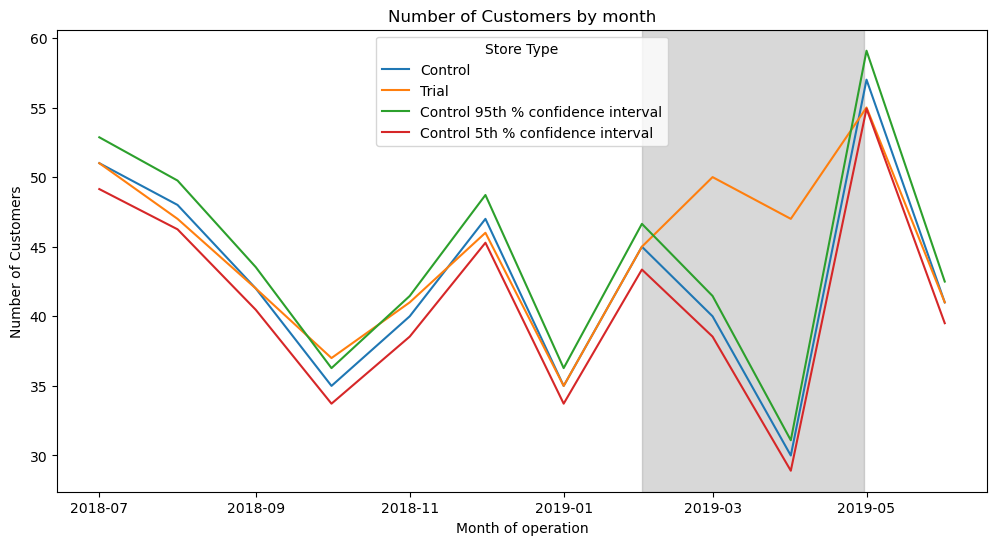

In [119]:
# aggregate customers by year-month and store type
past_custs = measure_over_time_custs.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()

# convert YEARMONTH to datetime
past_custs["TransactionMonth"] = pd.to_datetime(past_custs["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# filter for trial and control stores
past_custs = past_custs[past_custs["Store_type"].isin(["Trial", "Control"])]

# compute 95th and 5th percentiles for control store
past_custs_controls_95 = past_custs[past_custs["Store_type"] == "Control"].copy()
past_custs_controls_95["nCustomers"] = past_custs_controls_95["nCustomers"] * (1 + std_dev_custs * 2)
past_custs_controls_95["Store_type"] = "Control 95th % confidence interval"

past_custs_controls_5 = past_custs[past_custs["Store_type"] == "Control"].copy()
past_custs_controls_5["nCustomers"] = past_custs_controls_5["nCustomers"] * (1 - std_dev_custs * 2)
past_custs_controls_5["Store_type"] = "Control 5th % confidence interval"

# combine all datasets for visualization
trial_assessment_custs = pd.concat([past_custs, past_custs_controls_95, past_custs_controls_5])

# plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_custs, x="TransactionMonth", y="nCustomers", hue="Store_type")

# highlight the trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3)

# Labels
plt.xlabel("Month of operation")
plt.ylabel("Number of Customers")
plt.title("Number of Customers by month")
plt.legend(title="Store Type")
plt.show()

Findings:  
-  Before the Trial (Jul 2018 - Jan 2019):  
    -  The trial store and control store follow a similar trend, confirming that they had similar seasonal patterns before the intervention.  
    -  The trial store's customer count stays within the confidence interval of the control store, indicating no significant deviations.  
-  During the Trial Period (Feb 2019 - Apr 2019):  
    -  Trial store's customer count increased and exceeded the 95th percentile confidence interval in March and April 2019.  
    -  This suggests that the marketing campaign successfully increased customer footfall, as the observed customer increase is beyond normal variations.  

Conclusions:  
-  The intervention (e.g., marketing campaign) was effective in attracting more customers.    
-  Significant effect in two out of four trial months.    
-  This aligns with the earlier findings on total sales uplift, further confirming that the intervention had a positive impact on store performance.

## 4.3 Assess on Trial Store No.86

### 4.3.1 Find Control Store

1. Compute each similarity score in terms of monthly total sales in dollar amounts and monthly number of customers

In [120]:
# define trial store
trial_store = 86

# compute correlation-based similarity
corr_nSales_86 = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers_86 = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

# compute magnitude-based similarity
magnitude_nSales_86 = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers_86 = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

In [121]:
corr_nSales_86

,Store1,Store2,corr_measure
0,86,1,0.445632
1,86,2,-0.403835
2,86,3,-0.261284
3,86,4,-0.039035
4,86,5,0.235159
...,...,...,...
254,86,268,-0.452182
255,86,269,0.697055
256,86,270,-0.730679
257,86,271,0.527637


2. Combine all the scores to create a composite score to rank on

In [122]:
# define weight
corr_weight = 0.5

# compute combined similarity scores
score_nSales_86 = corr_nSales_86.merge(magnitude_nSales_86, on=["Store1", "Store2"])
score_nSales_86["scoreNSales"] = (
    score_nSales_86["corr_measure"] * corr_weight + score_nSales_86["mag_measure"] * (1 - corr_weight)
)

score_nCustomers_86 = corr_nCustomers_86.merge(magnitude_nCustomers_86, on=["Store1", "Store2"])
score_nCustomers_86["scoreNCust"] = (
    score_nCustomers_86["corr_measure"] * corr_weight + score_nCustomers_86["mag_measure"] * (1 - corr_weight)
)

# combine the two scores
score_Control_86 = score_nSales_86.merge(score_nCustomers_86, on=["Store1", "Store2"])
score_Control_86["finalControlScore"] = (
    score_Control_86["scoreNSales"] * 0.5 + score_Control_86["scoreNCust"] * 0.5
)

3. Select the final control store: The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [123]:
# select control store for the trial store (excluding itself)
control_store_86 = (
    score_Control_86[score_Control_86["Store1"] == trial_store]
    .sort_values(by="finalControlScore", ascending=False)
    .iloc[0]["Store2"]  # select the second highest store (excluding trial store itself)
)

print(control_store_86)

155


4. Visually check if the drivers are indeed similar in the period before the trial

In [124]:
# assign store type labels
measure_over_time_sales_86 = measure_over_time
measure_over_time_sales_86["Store_type"] = measure_over_time_sales_86["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else 
              "Control" if x == control_store_86 else 
              "Other stores"
)

measure_over_time_custs_86 = measure_over_time
measure_over_time_custs_86["Store_type"] = measure_over_time_custs_86["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else 
              "Control" if x == control_store_86 else 
              "Other stores"
)

# grouping by year-month and store type
pastSales_86 = measure_over_time_sales_86.groupby(["YEARMONTH", "Store_type"], as_index=False)["totSales"].mean()
pastCustomers_86 = measure_over_time_custs_86.groupby(["YEARMONTH", "Store_type"], as_index=False)["nCustomers"].mean()

# convert YEARMONTH to datetime format
pastSales_86["TransactionMonth"] = pd.to_datetime(
    pastSales_86["YEARMONTH"].astype(str), format="%Y%m"
)
pastCustomers_86["TransactionMonth"] = pd.to_datetime(
    pastCustomers_86["YEARMONTH"].astype(str), format="%Y%m"
)

# filter data before March 2019
pastSales_86 = pastSales_86[pastSales_86["YEARMONTH"] < 201903]
pastCustomers_86 = pastCustomers_86[pastCustomers_86["YEARMONTH"] < 201903]

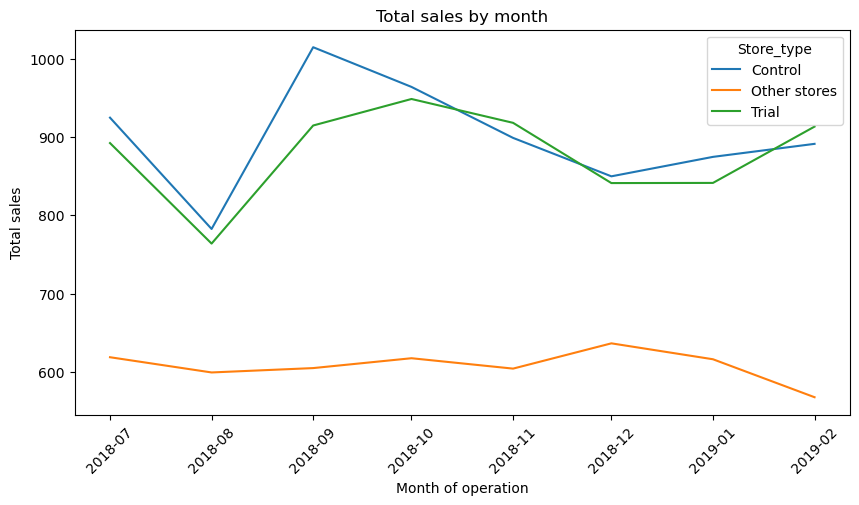

In [125]:
# plot sales trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=pastSales_86, x="TransactionMonth", y="totSales", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.xticks(rotation=45)
plt.show()

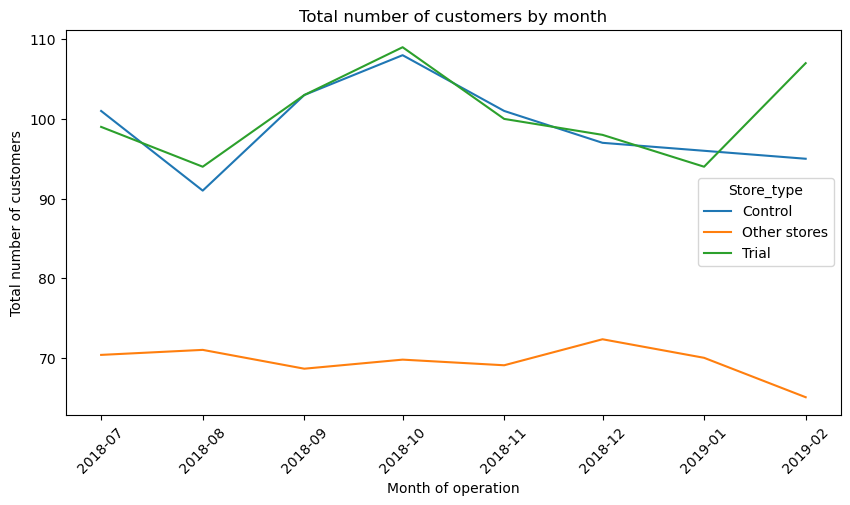

In [126]:
# plot customer trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=pastCustomers_86, x="TransactionMonth", y="nCustomers", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.xticks(rotation=45)
plt.show()

Findings: the two drivers (total sales and number of customers) are indeed similar in the period before the trial.

### 4.3.2 Assess on Trial Store No.86 in terms of total sales

1. Scale Control Store sales to match Trial Store sales during pre-trial period

In [127]:
# compute scaling factor
scaling_factor_for_control_sales_86 = (
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "totSales"
    ].sum() /
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == control_store_86) & (pre_trial_measures["YEARMONTH"] < 201902),
        "totSales"
    ].sum()
) # one factor for each store pair

# apply the scaling factor to control store's sales in each month
measure_over_time_sales_86 = measure_over_time.copy()

measure_over_time_sales_86.loc[
    measure_over_time_sales_86["STORE_NBR"] == control_store_86, "controlSales"
] = measure_over_time_sales_86["totSales"] * scaling_factor_for_control_sales_86

In [128]:
scaling_factor_for_control_sales_86

0.9700651481287743

In [130]:
measure_over_time_sales_86[measure_over_time_sales_86["STORE_NBR"] == 155]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlSales
1793,155,201807,924.60,101,1.217822,250.000000,0.002018,Control,896.922236
1794,155,201808,782.70,91,1.293478,76.333333,0.001622,Control,759.269991
1795,155,201809,1014.40,103,1.398058,290.000000,0.002163,Control,984.034086
1796,155,201810,963.80,108,1.259259,272.000000,0.001994,Control,934.948790
1797,155,201811,898.80,101,1.303922,270.000000,0.001892,Control,871.894555
1798,155,201812,849.80,97,1.237113,242.000000,0.001834,Control,824.361363
1799,155,201901,874.60,96,1.302083,252.000000,0.001895,Control,848.418979
1800,155,201902,891.20,95,1.315789,254.000000,0.001907,Control,864.522060
1801,155,201903,804.40,94,1.255319,240.000000,0.001881,Control,780.320405
1802,155,201904,844.60,99,1.212121,242.000000,0.001748,Control,819.317024


2. Scale Control Store sales to match Trial Store sales during trial period

In [131]:
percentage_diff_sales_86 = pd.merge(
    measure_over_time_sales_86.loc[measure_over_time_sales_86["STORE_NBR"] == control_store_86, ["YEARMONTH", "controlSales"]],
    measure_over_time_sales_86.loc[measure_over_time_sales_86["STORE_NBR"] == trial_store, ["YEARMONTH", "totSales"]],
    on="YEARMONTH"
)

percentage_diff_sales_86["percentageDiff"] = np.abs(percentage_diff_sales_86["controlSales"] - percentage_diff_sales_86["totSales"]) / percentage_diff_sales_86["controlSales"]

percentage_diff_sales_86

,YEARMONTH,controlSales,totSales,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


3. Assess statistical significance

In [132]:
# calculate the std of pre-trial period
std_dev_sales_86 = percentage_diff_sales_86.loc[percentage_diff_sales_86["YEARMONTH"] < 201902, "percentageDiff"].std()
degrees_of_freedom = 6

# calculate t-value
percentage_diff_sales_86["tValue"] = (percentage_diff_sales_86["percentageDiff"] - 0) / std_dev_sales_86
percentage_diff_sales_86["TransactionMonth"] = pd.to_datetime(
    percentage_diff_sales_86["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# focus on the t-value in trial period
t_values_trial_period_sales_86 = percentage_diff_sales_86[
    (percentage_diff_sales_86["YEARMONTH"] < 201905) & (percentage_diff_sales_86["YEARMONTH"] > 201901)
][["TransactionMonth", "tValue"]]

t_values_trial_period_sales_86

,TransactionMonth,tValue
7,2019-02-01,2.179542
8,2019-03-01,12.226922
9,2019-04-01,1.364580


In [133]:
# find the 95th percentile of the t-distribution
t_threshold = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile t-value: {t_threshold}")

95th percentile t-value: 1.9431802803927816


4. Visualize Sales Data Over Time

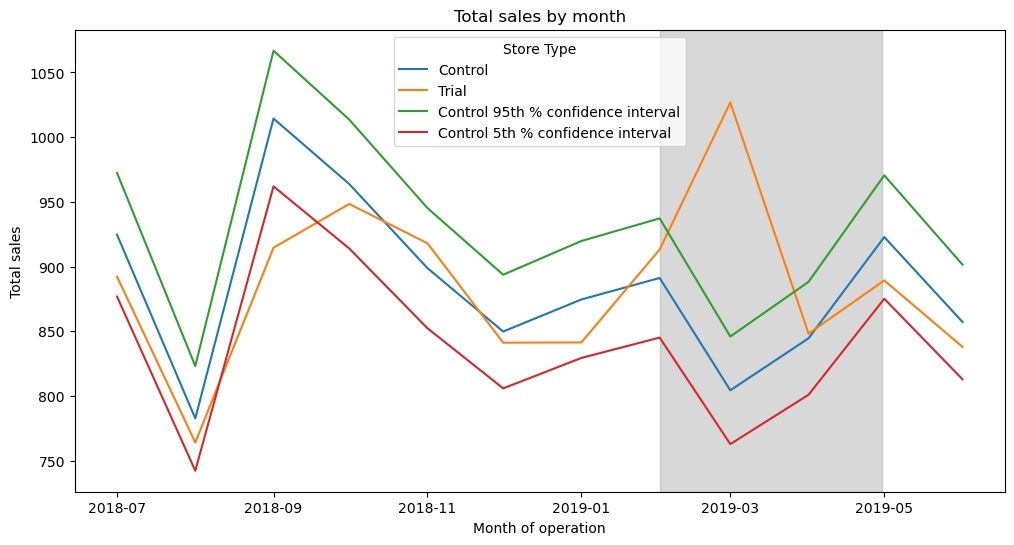

In [134]:
# aggregate sales by year-month and store type
past_sales_86 = measure_over_time_sales_86.groupby(["YEARMONTH", "Store_type"])["totSales"].mean().reset_index()

# convert YEARMONTH to datetime
past_sales_86["TransactionMonth"] = pd.to_datetime(past_sales_86["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# filter for trial and control stores
past_sales_86 = past_sales_86[past_sales_86["Store_type"].isin(["Trial", "Control"])]

# compute 95th and 5th percentiles for control store
past_sales_86_controls_95 = past_sales_86[past_sales_86["Store_type"] == "Control"].copy()
past_sales_86_controls_95["totSales"] = past_sales_86_controls_95["totSales"] * (1 + std_dev_sales_86 * 2)
past_sales_86_controls_95["Store_type"] = "Control 95th % confidence interval"

past_sales_86_controls_5 = past_sales_86[past_sales_86["Store_type"] == "Control"].copy()
past_sales_86_controls_5["totSales"] = past_sales_86_controls_5["totSales"] * (1 - std_dev_sales_86 * 2)
past_sales_86_controls_5["Store_type"] = "Control 5th % confidence interval"

# combine all datasets for visualization
trial_assessment_sales_86 = pd.concat([past_sales_86, past_sales_86_controls_95, past_sales_86_controls_5])

# plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_sales_86, x="TransactionMonth", y="totSales", hue="Store_type")

# highlight the trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3)

# Labels
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend(title="Store Type")
plt.show()

Findings: The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

### 4.3.3 Assess on Trial Store No.86 in terms of number of customers

1. Scale Control Store customers to match Trial Store customers during pre-trial period

In [136]:
# compute scaling factor
scaling_factor_for_control_custs_86 = (
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "nCustomers"
    ].sum() /
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == control_store_86) & (pre_trial_measures["YEARMONTH"] < 201902),
        "nCustomers"
    ].sum()
) # one factor for each store pair

# apply the scaling factor to control store's sales in each month
measure_over_time_custs_86 = measure_over_time.copy()

measure_over_time_custs_86.loc[
    measure_over_time_custs_86["STORE_NBR"] == control_store_86, "controlCusts"
] = measure_over_time_custs_86["nCustomers"] * scaling_factor_for_control_custs_86

In [137]:
scaling_factor_for_control_custs_86

1.0

In [138]:
measure_over_time_custs_86[measure_over_time_custs_86["STORE_NBR"] == 155]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlCusts
1793,155,201807,924.60,101,1.217822,250.000000,0.002018,Control,101.0
1794,155,201808,782.70,91,1.293478,76.333333,0.001622,Control,91.0
1795,155,201809,1014.40,103,1.398058,290.000000,0.002163,Control,103.0
1796,155,201810,963.80,108,1.259259,272.000000,0.001994,Control,108.0
1797,155,201811,898.80,101,1.303922,270.000000,0.001892,Control,101.0
1798,155,201812,849.80,97,1.237113,242.000000,0.001834,Control,97.0
1799,155,201901,874.60,96,1.302083,252.000000,0.001895,Control,96.0
1800,155,201902,891.20,95,1.315789,254.000000,0.001907,Control,95.0
1801,155,201903,804.40,94,1.255319,240.000000,0.001881,Control,94.0
1802,155,201904,844.60,99,1.212121,242.000000,0.001748,Control,99.0


2. Scale Control Store customers to match Trial Store customers during trial period

In [139]:
percentage_diff_custs_86 = pd.merge(
    measure_over_time_custs_86.loc[measure_over_time_custs_86["STORE_NBR"] == control_store_86, ["YEARMONTH", "controlCusts"]],
    measure_over_time_custs_86.loc[measure_over_time_custs_86["STORE_NBR"] == trial_store, ["YEARMONTH", "nCustomers"]],
    on="YEARMONTH"
)

percentage_diff_custs_86["percentageDiff"] = np.abs(percentage_diff_custs_86["controlCusts"] - percentage_diff_custs_86["nCustomers"]) / percentage_diff_custs_86["controlCusts"]

percentage_diff_custs_86

,YEARMONTH,controlCusts,nCustomers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901
5,201812,97.0,98,0.010309
6,201901,96.0,94,0.020833
7,201902,95.0,107,0.126316
8,201903,94.0,115,0.223404
9,201904,99.0,105,0.060606


3. Assess statistical significance

In [140]:
# calculate the std of pre-trial period
std_dev_custs_86 = percentage_diff_custs_86.loc[percentage_diff_custs_86["YEARMONTH"] < 201902, "percentageDiff"].std()
degrees_of_freedom = 6

# calculate t-value
percentage_diff_custs_86["tValue"] = (percentage_diff_custs_86["percentageDiff"] - 0) / std_dev_custs_86
percentage_diff_custs_86["TransactionMonth"] = pd.to_datetime(
    percentage_diff_custs_86["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# focus on the t-value in trial period
t_values_trial_period_custs_86 = percentage_diff_custs_86[
    (percentage_diff_custs_86["YEARMONTH"] < 201905) & (percentage_diff_custs_86["YEARMONTH"] > 201901)
][["TransactionMonth", "tValue"]]

t_values_trial_period_custs_86

,TransactionMonth,tValue
7,2019-02-01,11.819082
8,2019-03-01,20.903430
9,2019-04-01,5.670772


In [141]:
# find the 95th percentile of the t-distribution
t_threshold = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile t-value: {t_threshold}")

95th percentile t-value: 1.9431802803927816


4. Visualize Customers Data Over Time

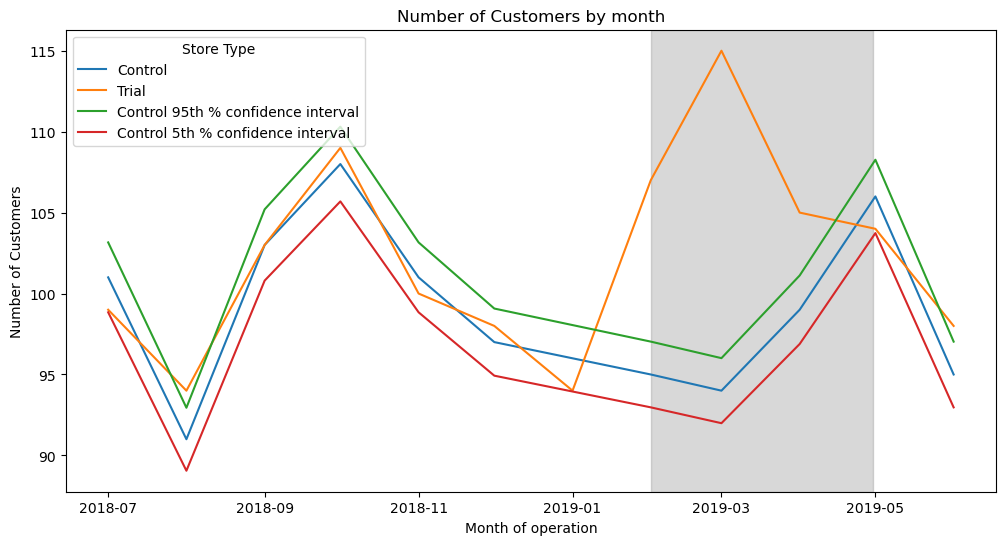

In [142]:
# aggregate customers by year-month and store type
past_custs_86 = measure_over_time_custs_86.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()

# convert YEARMONTH to datetime
past_custs_86["TransactionMonth"] = pd.to_datetime(past_custs_86["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# filter for trial and control stores
past_custs_86 = past_custs_86[past_custs_86["Store_type"].isin(["Trial", "Control"])]

# compute 95th and 5th percentiles for control store
past_custs_86_controls_95 = past_custs_86[past_custs_86["Store_type"] == "Control"].copy()
past_custs_86_controls_95["nCustomers"] = past_custs_86_controls_95["nCustomers"] * (1 + std_dev_custs_86 * 2)
past_custs_86_controls_95["Store_type"] = "Control 95th % confidence interval"

past_custs_86_controls_5 = past_custs_86[past_custs_86["Store_type"] == "Control"].copy()
past_custs_86_controls_5["nCustomers"] = past_custs_86_controls_5["nCustomers"] * (1 - std_dev_custs_86 * 2)
past_custs_86_controls_5["Store_type"] = "Control 5th % confidence interval"

# combine all datasets for visualization
trial_assessment_custs_86 = pd.concat([past_custs_86, past_custs_86_controls_95, past_custs_86_controls_5])

# plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_custs_86, x="TransactionMonth", y="nCustomers", hue="Store_type")

# highlight the trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3)

# Labels
plt.xlabel("Month of operation")
plt.ylabel("Number of Customers")
plt.title("Number of Customers by month")
plt.legend(title="Store Type")
plt.show()

Findings: It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86.

## 4.4 Assess on Trial Store No.88

### 4.4.1 Find Control Store

1. Compute each similarity score in terms of monthly total sales in dollar amounts and monthly number of customers

In [143]:
# define trial store
trial_store = 88

# compute correlation-based similarity
corr_nSales_88 = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers_88 = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

# compute magnitude-based similarity
magnitude_nSales_88 = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers_88 = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

2. Combine all the scores to create a composite score to rank on

In [144]:
# define weight
corr_weight = 0.5

# compute combined similarity scores
score_nSales_88 = corr_nSales_88.merge(magnitude_nSales_88, on=["Store1", "Store2"])
score_nSales_88["scoreNSales"] = (
    score_nSales_88["corr_measure"] * corr_weight + score_nSales_88["mag_measure"] * (1 - corr_weight)
)

score_nCustomers_88 = corr_nCustomers_88.merge(magnitude_nCustomers_88, on=["Store1", "Store2"])
score_nCustomers_88["scoreNCust"] = (
    score_nCustomers_88["corr_measure"] * corr_weight + score_nCustomers_88["mag_measure"] * (1 - corr_weight)
)

# combine the two scores
score_Control_88 = score_nSales_88.merge(score_nCustomers_88, on=["Store1", "Store2"])
score_Control_88["finalControlScore"] = (
    score_Control_88["scoreNSales"] * 0.5 + score_Control_88["scoreNCust"] * 0.5
)

3. Select the final control store: The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [145]:
# select control store for the trial store (excluding itself)
control_store_88 = (
    score_Control_88[score_Control_88["Store1"] == trial_store]
    .sort_values(by="finalControlScore", ascending=False)
    .iloc[0]["Store2"]  # select the second highest store (excluding trial store itself)
)

print(control_store_88)

237


4. Visually check if the drivers are indeed similar in the period before the trial

In [146]:
# assign store type labels
measure_over_time_sales_88 = measure_over_time
measure_over_time_sales_88["Store_type"] = measure_over_time_sales_88["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else 
              "Control" if x == control_store_88 else 
              "Other stores"
)

measure_over_time_custs_88 = measure_over_time
measure_over_time_custs_88["Store_type"] = measure_over_time_custs_88["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else 
              "Control" if x == control_store_88 else 
              "Other stores"
)

# grouping by year-month and store type
pastSales_88 = measure_over_time_sales_88.groupby(["YEARMONTH", "Store_type"], as_index=False)["totSales"].mean()
pastCustomers_88 = measure_over_time_custs_88.groupby(["YEARMONTH", "Store_type"], as_index=False)["nCustomers"].mean()

# convert YEARMONTH to datetime format
pastSales_88["TransactionMonth"] = pd.to_datetime(
    pastSales_88["YEARMONTH"].astype(str), format="%Y%m"
)
pastCustomers_88["TransactionMonth"] = pd.to_datetime(
    pastCustomers_88["YEARMONTH"].astype(str), format="%Y%m"
)

# filter data before March 2019
pastSales_88 = pastSales_88[pastSales_88["YEARMONTH"] < 201903]
pastCustomers_88 = pastCustomers_88[pastCustomers_88["YEARMONTH"] < 201903]

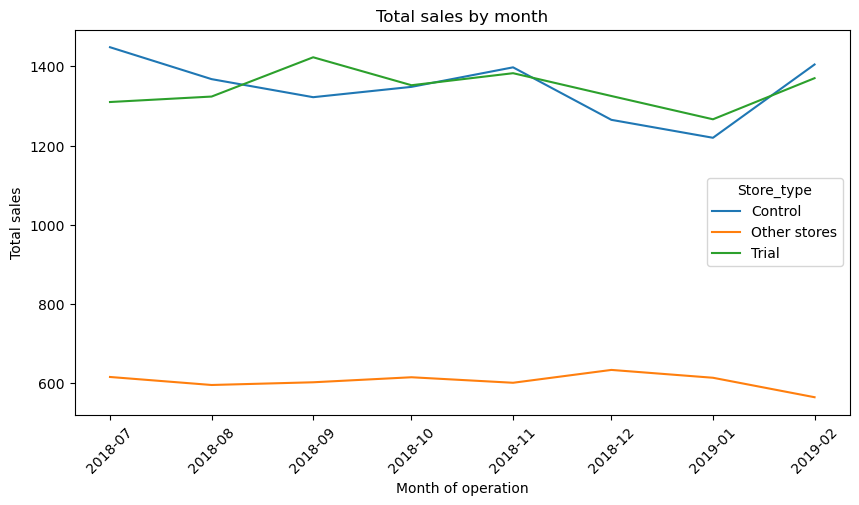

In [147]:
# plot sales trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=pastSales_88, x="TransactionMonth", y="totSales", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.xticks(rotation=45)
plt.show()

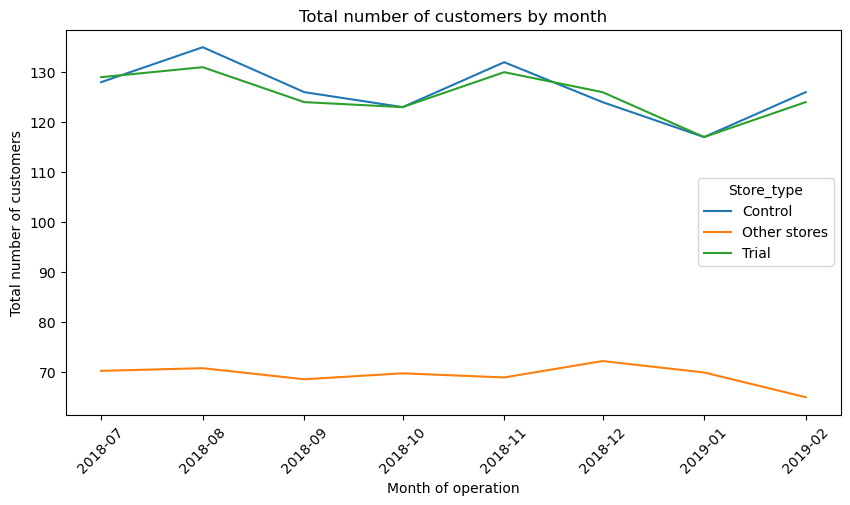

In [148]:
# plot customer trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=pastCustomers_88, x="TransactionMonth", y="nCustomers", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.xticks(rotation=45)
plt.show()

Findings: Findings: the two drivers (total sales and number of customers) are indeed similar in the period before the trial.

### 4.4.2 Assess on Trial Store No.88 in terms of total sales

1. Scale Control Store sales to match Trial Store sales during pre-trial period

In [149]:
# compute scaling factor
scaling_factor_for_control_sales_88 = (
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "totSales"
    ].sum() /
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == control_store_88) & (pre_trial_measures["YEARMONTH"] < 201902),
        "totSales"
    ].sum()
) # one factor for each store pair

# apply the scaling factor to control store's sales in each month
measure_over_time_sales_88 = measure_over_time.copy()

measure_over_time_sales_88.loc[
    measure_over_time_sales_88["STORE_NBR"] == control_store_88, "controlSales"
] = measure_over_time_sales_88["totSales"] * scaling_factor_for_control_sales_88

In [150]:
scaling_factor_for_control_sales_88

1.001558330664959

In [151]:
measure_over_time_sales_88[measure_over_time_sales_88["STORE_NBR"] == 237]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlSales
2747,237,201807,1448.4,128,1.265625,324.000000,0.004389,Control,1450.657086
2748,237,201808,1367.8,135,1.222222,78.250000,0.003631,Control,1369.931485
2749,237,201809,1322.2,126,1.182540,149.500000,0.003982,Control,1324.260425
2750,237,201810,1348.3,123,1.195122,149.500000,0.004067,Control,1350.401097
2751,237,201811,1397.6,132,1.219697,160.000000,0.003956,Control,1399.777923
2752,237,201812,1265.0,124,1.161290,144.500000,0.003795,Control,1266.971288
2753,237,201901,1219.7,117,1.188034,138.500000,0.003669,Control,1221.600696
2754,237,201902,1404.8,126,1.246032,314.000000,0.004257,Control,1406.989143
2755,237,201903,1208.2,119,1.126050,274.000000,0.003661,Control,1210.082775
2756,237,201904,1204.6,120,1.125000,272.000000,0.003650,Control,1206.477165


2. Scale Control Store sales to match Trial Store sales during trial period

In [152]:
percentage_diff_sales_88 = pd.merge(
    measure_over_time_sales_88.loc[measure_over_time_sales_88["STORE_NBR"] == control_store_88, ["YEARMONTH", "controlSales"]],
    measure_over_time_sales_88.loc[measure_over_time_sales_88["STORE_NBR"] == trial_store, ["YEARMONTH", "totSales"]],
    on="YEARMONTH"
)

percentage_diff_sales_88["percentageDiff"] = np.abs(percentage_diff_sales_88["controlSales"] - percentage_diff_sales_88["totSales"]) / percentage_diff_sales_88["controlSales"]

percentage_diff_sales_88

,YEARMONTH,controlSales,totSales,percentageDiff
0,201807,1450.657086,1310.00,0.096961
1,201808,1369.931485,1323.80,0.033674
2,201809,1324.260425,1423.00,0.074562
3,201810,1350.401097,1352.40,0.001480
4,201811,1399.777923,1382.80,0.012129
5,201812,1266.971288,1325.20,0.045959
6,201901,1221.600696,1266.40,0.036673
7,201902,1406.989143,1370.20,0.026147
8,201903,1210.082775,1477.20,0.220743
9,201904,1206.477165,1439.40,0.193060


3. Assess statistical significance

In [153]:
# calculate the std of pre-trial period
std_dev_sales_88 = percentage_diff_sales_88.loc[percentage_diff_sales_88["YEARMONTH"] < 201902, "percentageDiff"].std()
degrees_of_freedom = 6

# calculate t-value
percentage_diff_sales_88["tValue"] = (percentage_diff_sales_88["percentageDiff"] - 0) / std_dev_sales_88
percentage_diff_sales_88["TransactionMonth"] = pd.to_datetime(
    percentage_diff_sales_88["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# focus on the t-value in trial period
t_values_trial_period_sales_88 = percentage_diff_sales_88[
    (percentage_diff_sales_88["YEARMONTH"] < 201905) & (percentage_diff_sales_88["YEARMONTH"] > 201901)
][["TransactionMonth", "tValue"]]

t_values_trial_period_sales_88

,TransactionMonth,tValue
7,2019-02-01,0.781270
8,2019-03-01,6.595668
9,2019-04-01,5.768527


In [154]:
# find the 95th percentile of the t-distribution
t_threshold = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile t-value: {t_threshold}")

95th percentile t-value: 1.9431802803927816


4. Visualize Sales Data Over Time

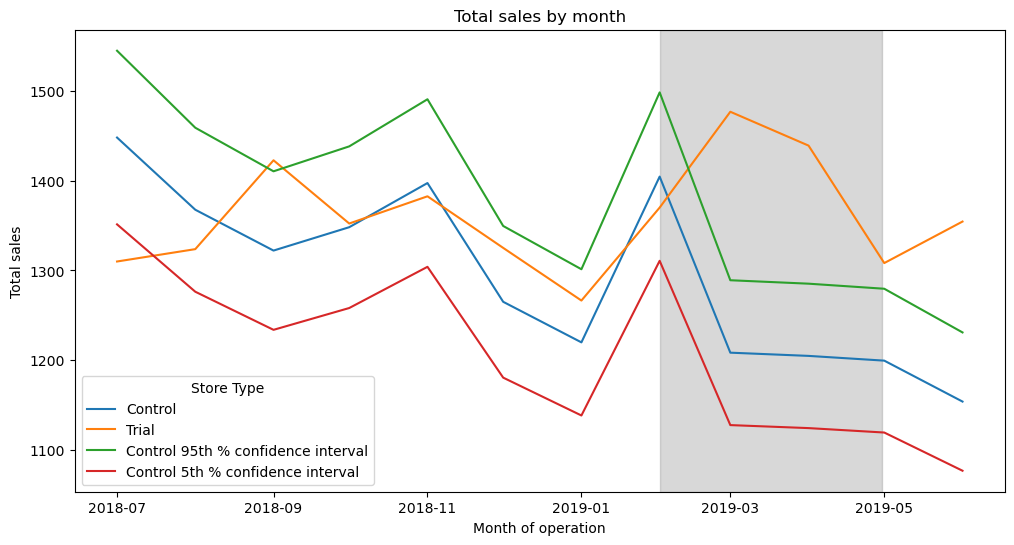

In [155]:
# aggregate sales by year-month and store type
past_sales_88 = measure_over_time_sales_88.groupby(["YEARMONTH", "Store_type"])["totSales"].mean().reset_index()

# convert YEARMONTH to datetime
past_sales_88["TransactionMonth"] = pd.to_datetime(past_sales_88["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# filter for trial and control stores
past_sales_88 = past_sales_88[past_sales_88["Store_type"].isin(["Trial", "Control"])]

# compute 95th and 5th percentiles for control store
past_sales_88_controls_95 = past_sales_88[past_sales_88["Store_type"] == "Control"].copy()
past_sales_88_controls_95["totSales"] = past_sales_88_controls_95["totSales"] * (1 + std_dev_sales_88 * 2)
past_sales_88_controls_95["Store_type"] = "Control 95th % confidence interval"

past_sales_88_controls_5 = past_sales_88[past_sales_88["Store_type"] == "Control"].copy()
past_sales_88_controls_5["totSales"] = past_sales_88_controls_5["totSales"] * (1 - std_dev_sales_88 * 2)
past_sales_88_controls_5["Store_type"] = "Control 5th % confidence interval"

# combine all datasets for visualization
trial_assessment_sales_88 = pd.concat([past_sales_88, past_sales_88_controls_95, past_sales_88_controls_5])

# plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_sales_88, x="TransactionMonth", y="totSales", hue="Store_type")

# highlight the trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3)

# Labels
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend(title="Store Type")
plt.show()

Findings: The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

### 4.4.3 Assess on Trial Store No.88 in terms of number of customers

1. Scale Control Store customers to match Trial Store customers during pre-trial period

In [156]:
# compute scaling factor
scaling_factor_for_control_custs_88 = (
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
        "nCustomers"
    ].sum() /
    pre_trial_measures.loc[
        (pre_trial_measures["STORE_NBR"] == control_store_88) & (pre_trial_measures["YEARMONTH"] < 201902),
        "nCustomers"
    ].sum()
) # one factor for each store pair

# apply the scaling factor to control store's sales in each month
measure_over_time_custs_88 = measure_over_time.copy()

measure_over_time_custs_88.loc[
    measure_over_time_custs_88["STORE_NBR"] == control_store_88, "controlCusts"
] = measure_over_time_custs_88["nCustomers"] * scaling_factor_for_control_custs_88

In [157]:
scaling_factor_for_control_custs_88

0.9943502824858758

In [158]:
measure_over_time_custs_88[measure_over_time_custs_88["STORE_NBR"] == 237]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlCusts
2747,237,201807,1448.4,128,1.265625,324.000000,0.004389,Control,127.276836
2748,237,201808,1367.8,135,1.222222,78.250000,0.003631,Control,134.237288
2749,237,201809,1322.2,126,1.182540,149.500000,0.003982,Control,125.288136
2750,237,201810,1348.3,123,1.195122,149.500000,0.004067,Control,122.305085
2751,237,201811,1397.6,132,1.219697,160.000000,0.003956,Control,131.254237
2752,237,201812,1265.0,124,1.161290,144.500000,0.003795,Control,123.299435
2753,237,201901,1219.7,117,1.188034,138.500000,0.003669,Control,116.338983
2754,237,201902,1404.8,126,1.246032,314.000000,0.004257,Control,125.288136
2755,237,201903,1208.2,119,1.126050,274.000000,0.003661,Control,118.327684
2756,237,201904,1204.6,120,1.125000,272.000000,0.003650,Control,119.322034


2. Scale Control Store customers to match Trial Store customers during trial period

In [159]:
percentage_diff_custs_88 = pd.merge(
    measure_over_time_custs_88.loc[measure_over_time_custs_88["STORE_NBR"] == control_store_88, ["YEARMONTH", "controlCusts"]],
    measure_over_time_custs_88.loc[measure_over_time_custs_88["STORE_NBR"] == trial_store, ["YEARMONTH", "nCustomers"]],
    on="YEARMONTH"
)

percentage_diff_custs_88["percentageDiff"] = np.abs(percentage_diff_custs_88["controlCusts"] - percentage_diff_custs_88["nCustomers"]) / percentage_diff_custs_88["controlCusts"]

percentage_diff_custs_88

,YEARMONTH,controlCusts,nCustomers,percentageDiff
0,201807,127.276836,129,0.013539
1,201808,134.237288,131,0.024116
2,201809,125.288136,124,0.010281
3,201810,122.305085,123,0.005682
4,201811,131.254237,130,0.009556
5,201812,123.299435,126,0.021902
6,201901,116.338983,117,0.005682
7,201902,125.288136,124,0.010281
8,201903,118.327684,134,0.132448
9,201904,119.322034,128,0.072727


3. Assess statistical significance

In [160]:
# calculate the std of pre-trial period
std_dev_custs_88 = percentage_diff_custs_88.loc[percentage_diff_custs_88["YEARMONTH"] < 201902, "percentageDiff"].std()
degrees_of_freedom = 6

# calculate t-value
percentage_diff_custs_88["tValue"] = (percentage_diff_custs_88["percentageDiff"] - 0) / std_dev_custs_88
percentage_diff_custs_88["TransactionMonth"] = pd.to_datetime(
    percentage_diff_custs_88["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# focus on the t-value in trial period
t_values_trial_period_custs_88 = percentage_diff_custs_88[
    (percentage_diff_custs_88["YEARMONTH"] < 201905) & (percentage_diff_custs_88["YEARMONTH"] > 201901)
][["TransactionMonth", "tValue"]]

t_values_trial_period_custs_88

,TransactionMonth,tValue
7,2019-02-01,1.387456
8,2019-03-01,17.873693
9,2019-04-01,9.814423


In [161]:
# find the 95th percentile of the t-distribution
t_threshold = t.ppf(0.95, df=degrees_of_freedom)
print(f"95th percentile t-value: {t_threshold}")

95th percentile t-value: 1.9431802803927816


4. Visualize Customers Data Over Time

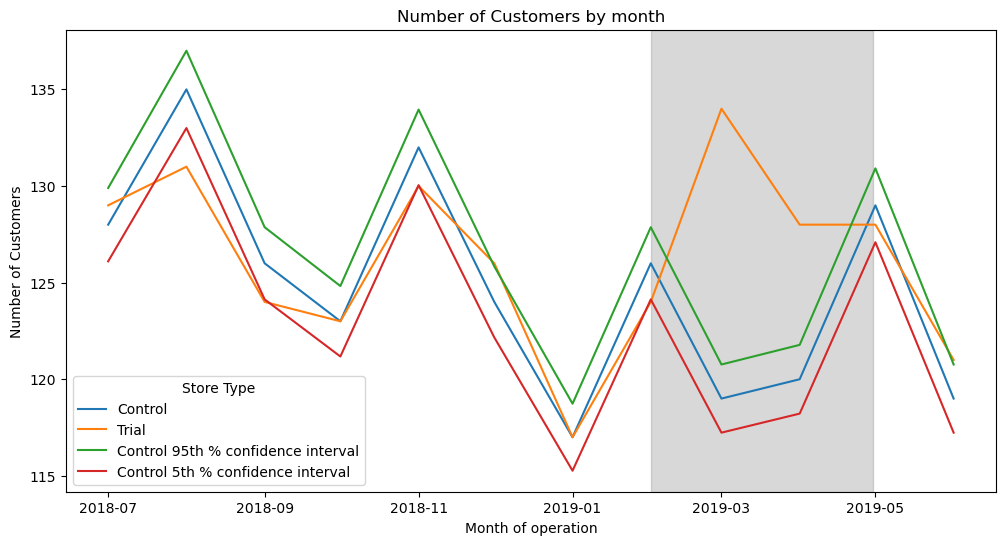

In [162]:
# aggregate customers by year-month and store type
past_custs_88 = measure_over_time_custs_88.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()

# convert YEARMONTH to datetime
past_custs_88["TransactionMonth"] = pd.to_datetime(past_custs_88["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# filter for trial and control stores
past_custs_88 = past_custs_88[past_custs_88["Store_type"].isin(["Trial", "Control"])]

# compute 95th and 5th percentiles for control store
past_custs_88_controls_95 = past_custs_88[past_custs_88["Store_type"] == "Control"].copy()
past_custs_88_controls_95["nCustomers"] = past_custs_88_controls_95["nCustomers"] * (1 + std_dev_custs_88 * 2)
past_custs_88_controls_95["Store_type"] = "Control 95th % confidence interval"

past_custs_88_controls_5 = past_custs_88[past_custs_88["Store_type"] == "Control"].copy()
past_custs_88_controls_5["nCustomers"] = past_custs_88_controls_5["nCustomers"] * (1 - std_dev_custs_88 * 2)
past_custs_88_controls_5["Store_type"] = "Control 5th % confidence interval"

# combine all datasets for visualization
trial_assessment_custs_88 = pd.concat([past_custs_88, past_custs_88_controls_95, past_custs_88_controls_5])

# plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_custs_88, x="TransactionMonth", y="nCustomers", hue="Store_type")

# highlight the trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"), color='grey', alpha=0.3)

# Labels
plt.xlabel("Month of operation")
plt.ylabel("Number of Customers")
plt.title("Number of Customers by month")
plt.legend(title="Store Type")
plt.show()

Findings: Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

# 5. Conclusions

We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.  
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation
 of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.